<a href="https://colab.research.google.com/github/jithsg/MODELING/blob/main/Model_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Hybrid NN-GP Model: MSE = 1.989344e-11, R² = 0.9982


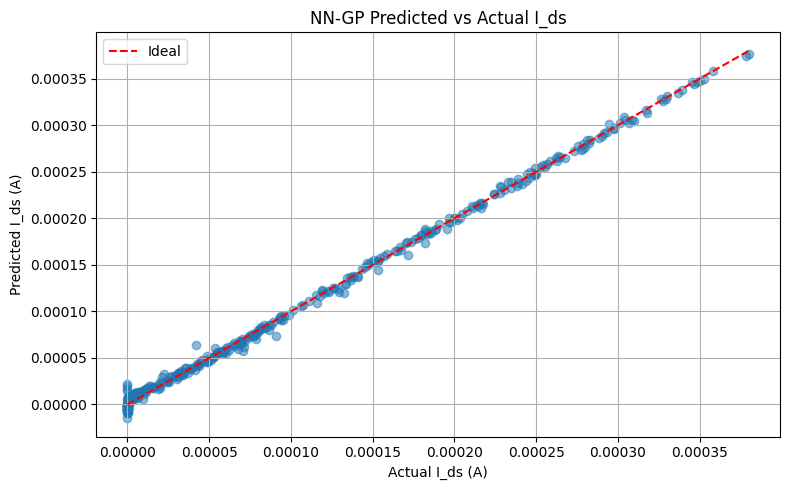

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Step 1: Load and clean dataset
df = pd.read_csv("/content/nfet_120_40.CSV")
df = df[['V_ds', 'V_gs', 'temp', 'I_ds']]
df['I_ds'] = pd.to_numeric(df['I_ds'], errors='coerce')
df.dropna(inplace=True)

# Step 2: Prepare features and target
X = df[['V_ds', 'V_gs', 'temp']].values
y = df['I_ds'].values.reshape(-1, 1)

# Step 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Standardization
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# Step 5: Train Neural Network
nn_model = MLPRegressor(hidden_layer_sizes=(50, 25), activation='relu', alpha=0.001,
                        max_iter=3000, random_state=42)
nn_model.fit(X_train_scaled, y_train_scaled.ravel())

# Predict with NN and inverse transform
y_nn_pred_scaled = nn_model.predict(X_test_scaled).reshape(-1, 1)
y_nn_pred = scaler_y.inverse_transform(y_nn_pred_scaled)

# Step 6: Compute NN residuals on training set
y_train_pred_scaled = nn_model.predict(X_train_scaled).reshape(-1, 1)
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
residuals = y_train - y_train_pred

# Step 7: Train GP on a subset of residuals (e.g., 300 samples)
subset_size = 300
indices = np.random.choice(len(X_train), subset_size, replace=False)
X_train_gp = X_train[indices]
residuals_gp = residuals[indices]

# Simplified kernel for faster GP fitting
kernel = ConstantKernel(1.0) * RBF(length_scale=1.0) + WhiteKernel(noise_level=1e-5)
gp_model = GaussianProcessRegressor(kernel=kernel, alpha=1e-6, normalize_y=True,
                                    n_restarts_optimizer=0, random_state=42)
gp_model.fit(X_train_gp, residuals_gp.ravel())

# Step 8: Predict GP correction
gp_correction, gp_std = gp_model.predict(X_test, return_std=True)
final_pred = y_nn_pred + gp_correction.reshape(-1, 1)

# Step 9: Evaluate
mse = mean_squared_error(y_test, final_pred)
r2 = r2_score(y_test, final_pred)
print(f"Hybrid NN-GP Model: MSE = {mse:.6e}, R² = {r2:.4f}")

# Step 10: Plot predicted vs actual
plt.figure(figsize=(8, 5))
plt.scatter(y_test, final_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal')
plt.xlabel("Actual I_ds (A)")
plt.ylabel("Predicted I_ds (A)")
plt.title("NN-GP Predicted vs Actual I_ds")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


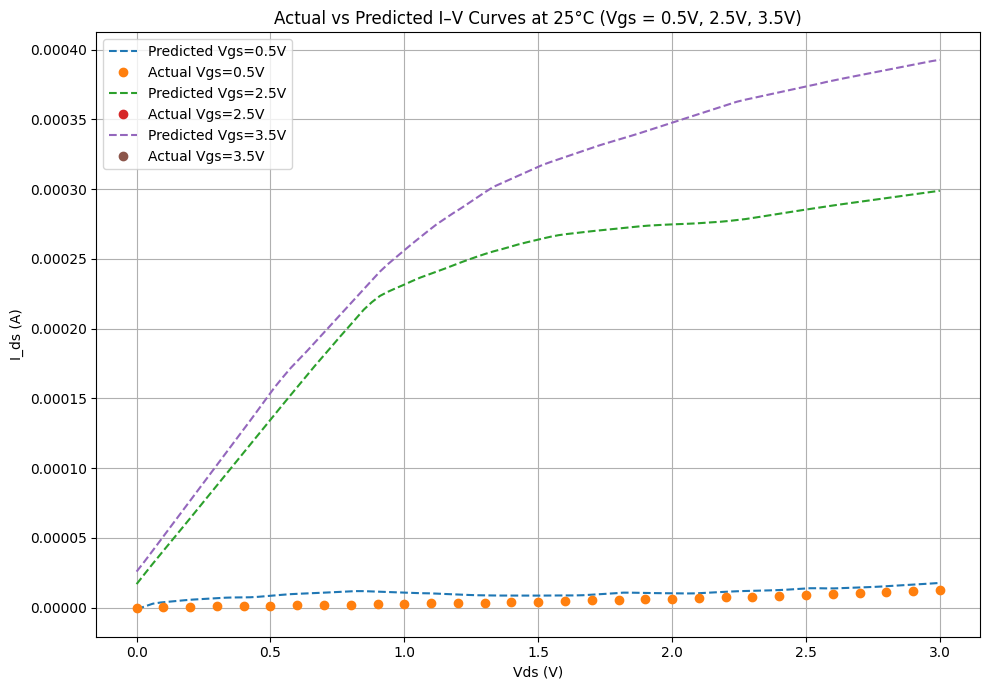

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Define parameters
vgs_values = [0.5, 2.5, 3.5]
temperature_fixed = 25
vds_range = np.linspace(df['V_ds'].min(), df['V_ds'].max(), 100)

# Start plot
plt.figure(figsize=(10, 7))

for vgs_val in vgs_values:
    # Generate grid for prediction
    vds_grid = vds_range
    vgs_grid = np.full_like(vds_grid, vgs_val)
    temp_grid = np.full_like(vds_grid, temperature_fixed)

    X_grid = np.stack([vds_grid, vgs_grid, temp_grid], axis=1)

    # NN prediction
    X_grid_scaled = scaler_X.transform(X_grid)
    y_nn_scaled = nn_model.predict(X_grid_scaled).reshape(-1, 1)
    y_nn = scaler_y.inverse_transform(y_nn_scaled)

    # GP correction
    gp_correction, _ = gp_model.predict(X_grid, return_std=True)
    y_final = y_nn.flatten() + gp_correction

    # Plot predicted I–V curve
    plt.plot(vds_grid, y_final, '--', label=f'Predicted Vgs={vgs_val}V')

    # Get actual data from original df
    actual_mask = (np.isclose(df['V_gs'], vgs_val, atol=0.01)) & (df['temp'] == temperature_fixed)
    actual_data = df[actual_mask].sort_values(by='V_ds')

    # Plot actual I–V curve
    plt.plot(actual_data['V_ds'], actual_data['I_ds'], 'o', label=f'Actual Vgs={vgs_val}V')

# Labels and formatting
plt.xlabel("Vds (V)")
plt.ylabel("I_ds (A)")
plt.title("Actual vs Predicted I–V Curves at 25°C (Vgs = 0.5V, 2.5V, 3.5V)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


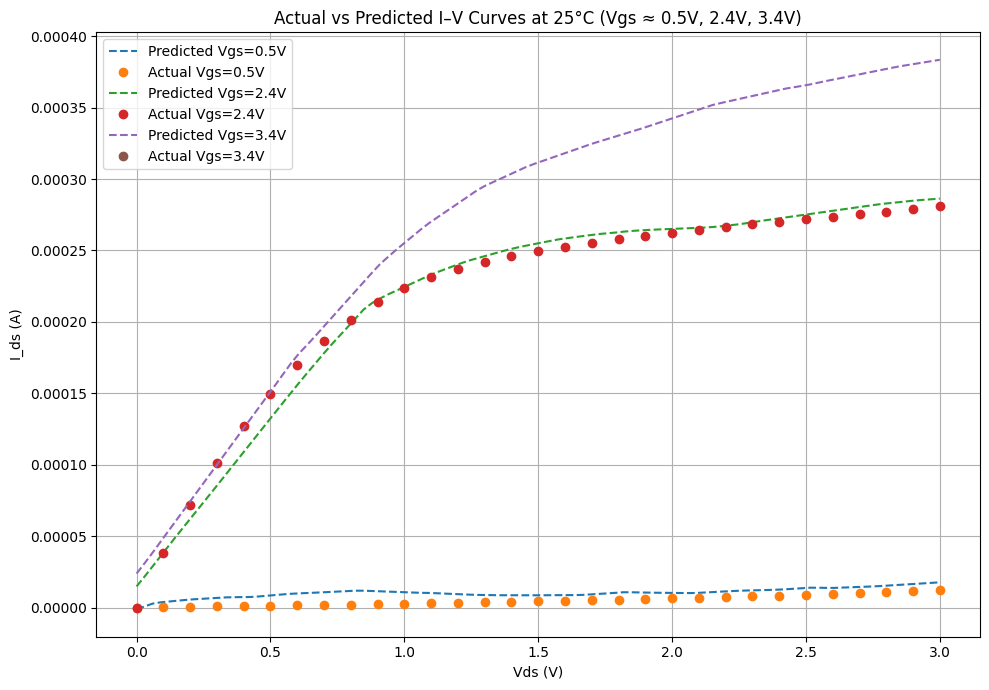

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Use available Vgs values from the dataset
vgs_values_updated = [0.5, 2.4, 3.4]
temperature_fixed = 25  # fixed temperature
vds_range = np.linspace(df['V_ds'].min(), df['V_ds'].max(), 100)

# Initialize plot
plt.figure(figsize=(10, 7))

for vgs_val in vgs_values_updated:
    # Generate a grid of inputs for prediction
    vds_grid = vds_range
    vgs_grid = np.full_like(vds_grid, vgs_val)
    temp_grid = np.full_like(vds_grid, temperature_fixed)

    X_grid = np.stack([vds_grid, vgs_grid, temp_grid], axis=1)

    # Scale input and predict using NN
    X_grid_scaled = scaler_X.transform(X_grid)
    y_nn_scaled = nn_model.predict(X_grid_scaled).reshape(-1, 1)
    y_nn = scaler_y.inverse_transform(y_nn_scaled)

    # GP residual correction
    gp_correction, _ = gp_model.predict(X_grid, return_std=True)
    y_final = y_nn.flatten() + gp_correction

    # Plot predicted I–V curve
    plt.plot(vds_grid, y_final, '--', label=f'Predicted Vgs={vgs_val}V')

    # Filter actual data for this Vgs and temperature
    actual_mask = (np.isclose(df['V_gs'], vgs_val, atol=0.01)) & (df['temp'] == temperature_fixed)
    actual_data = df[actual_mask].sort_values(by='V_ds')

    # Plot actual I–V curve
    plt.plot(actual_data['V_ds'], actual_data['I_ds'], 'o', label=f'Actual Vgs={vgs_val}V')

# Labeling and display
plt.xlabel("Vds (V)")
plt.ylabel("I_ds (A)")
plt.title("Actual vs Predicted I–V Curves at 25°C (Vgs ≈ 0.5V, 2.4V, 3.4V)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


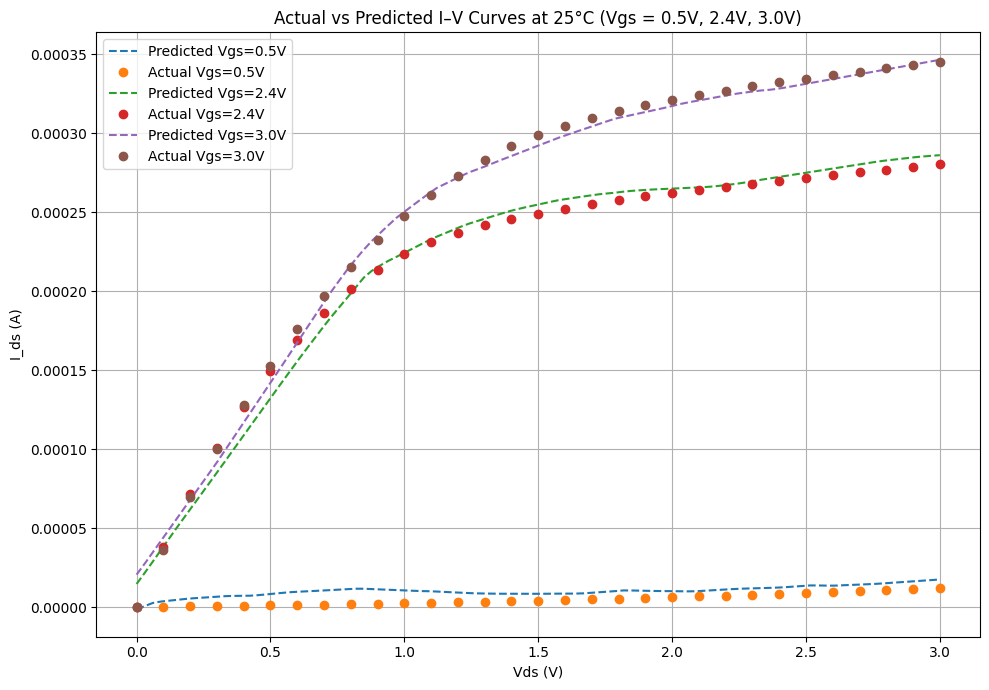

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Define final available Vgs values for plotting
vgs_values_final = [0.5, 2.4, 3.0]
temperature_fixed = 25  # Temperature in °C
vds_range = np.linspace(df['V_ds'].min(), df['V_ds'].max(), 100)

# Initialize plot
plt.figure(figsize=(10, 7))

for vgs_val in vgs_values_final:
    # Create grid for prediction
    vds_grid = vds_range
    vgs_grid = np.full_like(vds_grid, vgs_val)
    temp_grid = np.full_like(vds_grid, temperature_fixed)

    X_grid = np.stack([vds_grid, vgs_grid, temp_grid], axis=1)

    # Predict using NN + GP
    X_grid_scaled = scaler_X.transform(X_grid)
    y_nn_scaled = nn_model.predict(X_grid_scaled).reshape(-1, 1)
    y_nn = scaler_y.inverse_transform(y_nn_scaled)
    gp_correction, _ = gp_model.predict(X_grid, return_std=True)
    y_final = y_nn.flatten() + gp_correction

    # Plot predicted I–V curve
    plt.plot(vds_grid, y_final, '--', label=f'Predicted Vgs={vgs_val}V')

    # Plot actual data
    actual_mask = (np.isclose(df['V_gs'], vgs_val, atol=0.01)) & (df['temp'] == temperature_fixed)
    actual_data = df[actual_mask].sort_values(by='V_ds')
    plt.plot(actual_data['V_ds'], actual_data['I_ds'], 'o', label=f'Actual Vgs={vgs_val}V')

# Final plot formatting
plt.xlabel("Vds (V)")
plt.ylabel("I_ds (A)")
plt.title("Actual vs Predicted I–V Curves at 25°C (Vgs = 0.5V, 2.4V, 3.0V)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


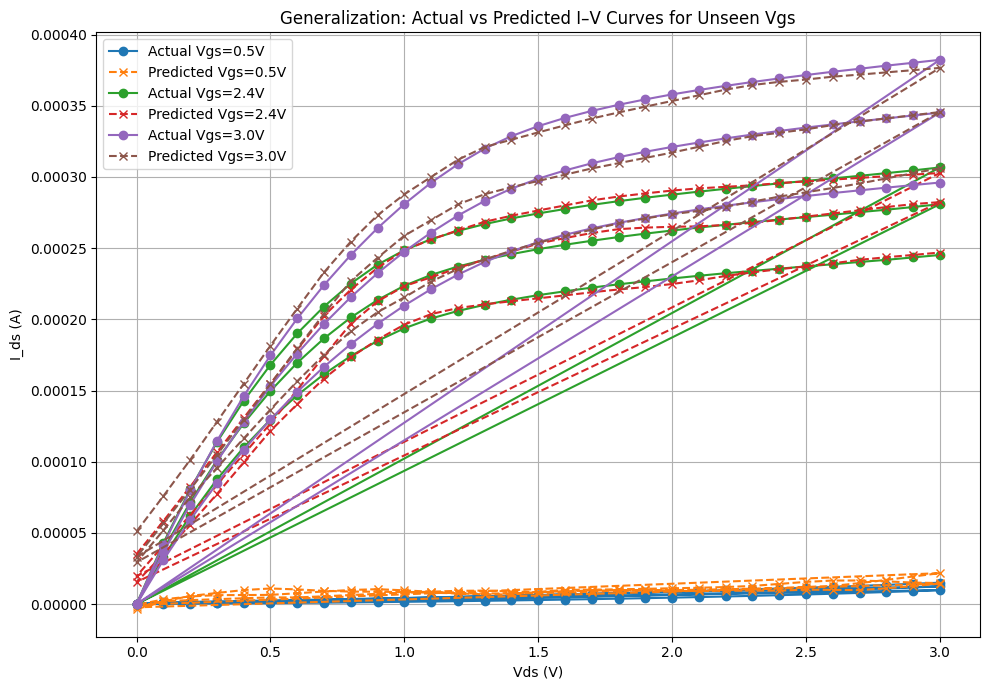

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel

# Assumes df is already loaded and cleaned with columns: V_ds, V_gs, temp, I_ds

# Step 1: Define unseen Vgs values
excluded_vgs = [0.5, 2.4, 3.0]

# Step 2: Split dataset
train_df = df[~df['V_gs'].isin(excluded_vgs)]
test_df = df[df['V_gs'].isin(excluded_vgs)]

# Step 3: Prepare training inputs
X_train = train_df[['V_ds', 'V_gs', 'temp']].values
y_train = train_df['I_ds'].values.reshape(-1, 1)

# Step 4: Standardize inputs
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train)

# Step 5: Train Neural Network
nn_model = MLPRegressor(hidden_layer_sizes=(50, 25), activation='relu', alpha=0.001,
                        max_iter=3000, random_state=42)
nn_model.fit(X_train_scaled, y_train_scaled.ravel())

# Step 6: Get residuals for GP
y_train_pred_scaled = nn_model.predict(X_train_scaled).reshape(-1, 1)
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
residuals = y_train - y_train_pred

# Step 7: Train GP on subset of residuals
subset_size = 300
subset_indices = np.random.choice(len(X_train), subset_size, replace=False)
X_gp = X_train[subset_indices]
residuals_gp = residuals[subset_indices]

kernel = ConstantKernel(1.0) * RBF(length_scale=1.0) + WhiteKernel(noise_level=1e-5)
gp_model = GaussianProcessRegressor(kernel=kernel, alpha=1e-6, normalize_y=True,
                                    n_restarts_optimizer=0, random_state=42)
gp_model.fit(X_gp, residuals_gp.ravel())

# Step 8: Prepare test set for excluded Vgs
X_test = test_df[['V_ds', 'V_gs', 'temp']].values
y_test = test_df['I_ds'].values.reshape(-1, 1)
X_test_scaled = scaler_X.transform(X_test)

# Step 9: Predict with Hybrid NN–GP
y_nn_test_scaled = nn_model.predict(X_test_scaled).reshape(-1, 1)
y_nn_test = scaler_y.inverse_transform(y_nn_test_scaled)
gp_correction, _ = gp_model.predict(X_test, return_std=True)
y_final = y_nn_test + gp_correction.reshape(-1, 1)

# Step 10: Plot I–V curves for unseen Vgs
X_test_orig = scaler_X.inverse_transform(X_test_scaled)
Vds_test = X_test_orig[:, 0]
Vgs_test = X_test_orig[:, 1]
Id_actual = y_test.flatten()
Id_predicted = y_final.flatten()

plt.figure(figsize=(10, 7))
for vgs_val in excluded_vgs:
    mask = np.isclose(Vgs_test, vgs_val, atol=0.01)
    plt.plot(Vds_test[mask], Id_actual[mask], 'o-', label=f'Actual Vgs={vgs_val}V')
    plt.plot(Vds_test[mask], Id_predicted[mask], 'x--', label=f'Predicted Vgs={vgs_val}V')

plt.xlabel("Vds (V)")
plt.ylabel("I_ds (A)")
plt.title("Generalization: Actual vs Predicted I–V Curves for Unseen Vgs")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


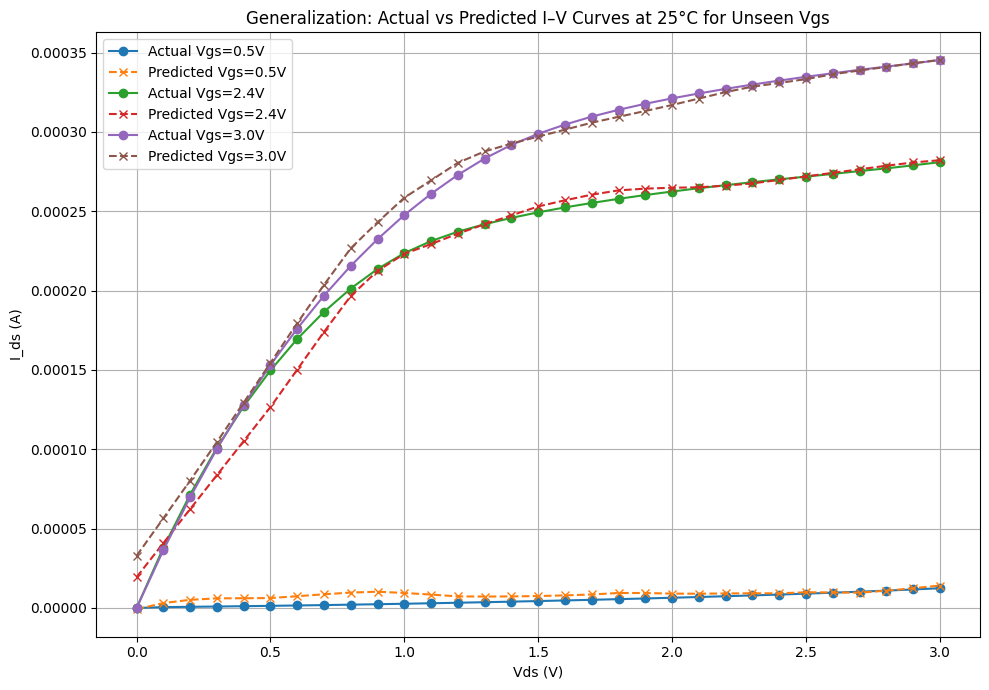

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel

# Assumes df is already loaded and cleaned with columns: V_ds, V_gs, temp, I_ds

# Define unseen Vgs values
excluded_vgs = [0.5, 2.4, 3.0]
temperature_fixed = 25

# Split dataset
train_df = df[~df['V_gs'].isin(excluded_vgs)]
test_df = df[df['V_gs'].isin(excluded_vgs)]
test_df_25C = test_df[test_df['temp'] == temperature_fixed]

# Prepare training data
X_train = train_df[['V_ds', 'V_gs', 'temp']].values
y_train = train_df['I_ds'].values.reshape(-1, 1)

# Standardize
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train)

# Train Neural Network
nn_model = MLPRegressor(hidden_layer_sizes=(50, 25), activation='relu', alpha=0.001,
                        max_iter=3000, random_state=42)
nn_model.fit(X_train_scaled, y_train_scaled.ravel())

# Compute residuals and train GP
y_train_pred_scaled = nn_model.predict(X_train_scaled).reshape(-1, 1)
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
residuals = y_train - y_train_pred

subset_size = 300
subset_indices = np.random.choice(len(X_train), subset_size, replace=False)
X_gp = X_train[subset_indices]
residuals_gp = residuals[subset_indices]

kernel = ConstantKernel(1.0) * RBF(length_scale=1.0) + WhiteKernel(noise_level=1e-5)
gp_model = GaussianProcessRegressor(kernel=kernel, alpha=1e-6, normalize_y=True,
                                    n_restarts_optimizer=0, random_state=42)
gp_model.fit(X_gp, residuals_gp.ravel())

# Predict on unseen Vgs at 25°C
X_test = test_df_25C[['V_ds', 'V_gs', 'temp']].values
y_test = test_df_25C['I_ds'].values.reshape(-1, 1)
X_test_scaled = scaler_X.transform(X_test)

y_nn_test_scaled = nn_model.predict(X_test_scaled).reshape(-1, 1)
y_nn_test = scaler_y.inverse_transform(y_nn_test_scaled)
gp_correction, _ = gp_model.predict(X_test, return_std=True)
y_final = y_nn_test + gp_correction.reshape(-1, 1)

# Plot comparison
X_test_orig = scaler_X.inverse_transform(X_test_scaled)
Vds_test = X_test_orig[:, 0]
Vgs_test = X_test_orig[:, 1]
Id_actual = y_test.flatten()
Id_predicted = y_final.flatten()

plt.figure(figsize=(10, 7))
for vgs_val in excluded_vgs:
    mask = np.isclose(Vgs_test, vgs_val, atol=0.01)
    plt.plot(Vds_test[mask], Id_actual[mask], 'o-', label=f'Actual Vgs={vgs_val}V')
    plt.plot(Vds_test[mask], Id_predicted[mask], 'x--', label=f'Predicted Vgs={vgs_val}V')

plt.xlabel("Vds (V)")
plt.ylabel("I_ds (A)")
plt.title("Generalization: Actual vs Predicted I–V Curves at 25°C for Unseen Vgs")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel
from sklearn.metrics import mean_squared_error, r2_score

# Define acquisition function
def acquisition_function(mean, std, gradient, iteration):
    exploration_weight = max(0.3, 0.8 - 0.1 * iteration)
    norm_std = std / np.max(std + 1e-10)
    norm_gradient = gradient / np.max(gradient + 1e-10)
    return exploration_weight * norm_std + (1 - exploration_weight) * norm_gradient

# PARAMETERS
vgs_target = [0.5, 2.4, 3.0]
iterations = 4
samples_per_iter = 5
temperature_fixed = 25

# df must be a preloaded DataFrame with columns: V_ds, V_gs, temp, I_ds
df_25C = df[df['temp'] == temperature_fixed]
vds_max = df_25C['V_ds'].max()

active_results = {}

# MAIN LOOP
for vgs in vgs_target:
    print(f"\nActive Learning for Vgs = {vgs}V")

    train_df = df_25C[df_25C['V_gs'] != vgs]
    test_df = df_25C[df_25C['V_gs'] == vgs].sort_values('V_ds')

    init_vds = np.linspace(0, vds_max, 5).reshape(-1, 1)
    init_vgs = np.full_like(init_vds, vgs)
    init_temp = np.full_like(init_vds, temperature_fixed)
    Vds_data = np.hstack([init_vds, init_vgs, init_temp])

    Id_data = test_df[test_df['V_ds'].isin(init_vds.flatten())]['I_ds'].values.reshape(-1, 1)

    Vds_test = test_df[['V_ds', 'V_gs', 'temp']].values
    Id_true = test_df['I_ds'].values.reshape(-1, 1)

    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    nn_model = MLPRegressor(hidden_layer_sizes=(50, 25), activation='relu', alpha=0.001,
                            max_iter=3000, random_state=42)
    kernel = ConstantKernel(1.0) * RBF(length_scale=1.0) + WhiteKernel(noise_level=1e-5)
    gp_model = GaussianProcessRegressor(kernel=kernel, alpha=1e-6, normalize_y=True,
                                        n_restarts_optimizer=0, random_state=42)

    mse_history, r2_history, sample_counts = [], [], []

    for iteration in range(iterations):
        print(f"  Iteration {iteration + 1}/{iterations}")
        X_scaled = scaler_X.fit_transform(Vds_data)
        y_scaled = scaler_y.fit_transform(Id_data)
        nn_model.fit(X_scaled, y_scaled.ravel())

        X_test_scaled = scaler_X.transform(Vds_test)
        y_pred_scaled = nn_model.predict(X_test_scaled).reshape(-1, 1)
        nn_pred = scaler_y.inverse_transform(y_pred_scaled)

        y_pred_train_scaled = nn_model.predict(X_scaled).reshape(-1, 1)
        y_pred_train = scaler_y.inverse_transform(y_pred_train_scaled)
        residuals = Id_data - y_pred_train
        gp_model.fit(Vds_data, residuals.ravel())

        gp_correction, gp_std = gp_model.predict(Vds_test, return_std=True)
        final_pred = nn_pred + gp_correction.reshape(-1, 1)

        mse = mean_squared_error(Id_true, final_pred)
        r2 = r2_score(Id_true.ravel(), final_pred.ravel())
        mse_history.append(mse)
        r2_history.append(r2)
        sample_counts.append(len(Vds_data))

        Vds_candidates = np.linspace(0, vds_max, 200).reshape(-1, 1)
        Vgs_candidates = np.full_like(Vds_candidates, vgs)
        Temp_candidates = np.full_like(Vds_candidates, temperature_fixed)
        X_candidates = np.hstack([Vds_candidates, Vgs_candidates, Temp_candidates])

        X_cand_scaled = scaler_X.transform(X_candidates)
        y_pred_cand_scaled = nn_model.predict(X_cand_scaled).reshape(-1, 1)
        y_pred_cand = scaler_y.inverse_transform(y_pred_cand_scaled)
        _, sigma = gp_model.predict(X_candidates, return_std=True)
        gradient = np.abs(np.gradient(y_pred_cand.flatten()))
        acq_values = acquisition_function(y_pred_cand.flatten(), sigma, gradient, iteration)

        idx_new = np.argsort(acq_values)[-samples_per_iter:]
        Vds_new = X_candidates[idx_new]
        Id_new = df_25C[
            (np.isclose(df_25C['V_gs'], vgs, atol=0.01)) &
            (np.isclose(df_25C['V_ds'], Vds_new[:, 0], atol=0.01))
        ]['I_ds'].values.reshape(-1, 1)

        Vds_data = np.vstack((Vds_data, Vds_new))
        Id_data = np.vstack((Id_data, Id_new))

    # Final Model
    X_scaled = scaler_X.fit_transform(Vds_data)
    y_scaled = scaler_y.fit_transform(Id_data)
    nn_model.fit(X_scaled, y_scaled.ravel())
    X_test_scaled = scaler_X.transform(Vds_test)
    y_pred_scaled = nn_model.predict(X_test_scaled).reshape(-1, 1)
    nn_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_pred_train_scaled = nn_model.predict(X_scaled).reshape(-1, 1)
    y_pred_train = scaler_y.inverse_transform(y_pred_train_scaled)
    residuals = Id_data - y_pred_train
    gp_model.fit(Vds_data, residuals.ravel())
    gp_correction, gp_std = gp_model.predict(Vds_test, return_std=True)
    final_pred = nn_pred + gp_correction.reshape(-1, 1)
    final_mse = mean_squared_error(Id_true, final_pred)
    final_r2 = r2_score(Id_true.ravel(), final_pred.ravel())

    active_results[vgs] = {
        'final_pred': final_pred,
        'Id_true': Id_true,
        'Vds_test': Vds_test[:, 0],
        'mse_history': mse_history,
        'r2_history': r2_history,
        'sample_counts': sample_counts
    }

# PLOT RESULTS
plt.figure(figsize=(10, 7))
for vgs in vgs_target:
    Vds = active_results[vgs]['Vds_test']
    Id_true = active_results[vgs]['Id_true'].flatten()
    Id_pred = active_results[vgs]['final_pred'].flatten()
    plt.plot(Vds, Id_true, 'o-', label=f'Actual Vgs={vgs}V')
    plt.plot(Vds, Id_pred, 'x--', label=f'Predicted Vgs={vgs}V')

plt.xlabel("Vds (V)")
plt.ylabel("I_ds (A)")
plt.title("Active Learning: Actual vs Predicted I–V Curves at 25°C")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



Active Learning for Vgs = 0.5V
  Iteration 1/4


ValueError: Found input variables with inconsistent numbers of samples: [5, 3]

In [9]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel
from sklearn.metrics import mean_squared_error, r2_score

# Helper to extract initial Id values
def get_initial_Id_data(Vds_data, df_source):
    Id_data = []
    for row in Vds_data:
        vd, vg, temp = row
        match = df_source[
            (np.isclose(df_source['V_ds'], vd, atol=1e-4)) &
            (np.isclose(df_source['V_gs'], vg, atol=1e-4)) &
            (df_source['temp'] == temp)
        ]
        if not match.empty:
            Id_data.append(match.iloc[0]['I_ds'])
    return np.array(Id_data).reshape(-1, 1)

# Corrected initial Vds–Id pair selection
def get_valid_initial_data(vgs_val, df_source, num_points=5, temperature=25):
    available_vds = df_source[
        (np.isclose(df_source['V_gs'], vgs_val, atol=1e-4)) &
        (df_source['temp'] == temperature)
    ]['V_ds'].unique()

    available_vds = np.sort(available_vds)
    if len(available_vds) < num_points:
        num_points = len(available_vds)
    init_vds = np.linspace(available_vds.min(), available_vds.max(), num_points)
    init_vds = np.round(init_vds, decimals=4).reshape(-1, 1)

    init_vgs = np.full_like(init_vds, vgs_val)
    init_temp = np.full_like(init_vds, temperature)
    Vds_data = np.hstack([init_vds, init_vgs, init_temp])
    Id_data = get_initial_Id_data(Vds_data, df_source)

    return Vds_data, Id_data

def acquisition_function(mean, std, gradient, iteration):
    exploration_weight = max(0.3, 0.8 - 0.1 * iteration)
    norm_std = std / np.max(std + 1e-10)
    norm_gradient = gradient / np.max(gradient + 1e-10)
    return exploration_weight * norm_std + (1 - exploration_weight) * norm_gradient

# MAIN SCRIPT
vgs_target = [0.5, 2.4, 3.0]
iterations = 4
samples_per_iter = 5
temperature_fixed = 25

df_25C = df[df['temp'] == temperature_fixed]
vds_max = df_25C['V_ds'].max()

active_results = {}

for vgs in vgs_target:
    print(f"\nActive Learning for Vgs = {vgs}V")
    Vds_data, Id_data = get_valid_initial_data(vgs, df_25C, num_points=5, temperature=temperature_fixed)

    test_df = df_25C[df_25C['V_gs'] == vgs].sort_values('V_ds')
    Vds_test = test_df[['V_ds', 'V_gs', 'temp']].values
    Id_true = test_df['I_ds'].values.reshape(-1, 1)

    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    nn_model = MLPRegressor(hidden_layer_sizes=(50, 25), activation='relu', alpha=0.001,
                            max_iter=3000, random_state=42)
    kernel = ConstantKernel(1.0) * RBF(length_scale=1.0) + WhiteKernel(noise_level=1e-5)
    gp_model = GaussianProcessRegressor(kernel=kernel, alpha=1e-6, normalize_y=True,
                                        n_restarts_optimizer=0, random_state=42)

    mse_history, r2_history, sample_counts = [], [], []

    for iteration in range(iterations):
        print(f"  Iteration {iteration + 1}/{iterations}")
        X_scaled = scaler_X.fit_transform(Vds_data)
        y_scaled = scaler_y.fit_transform(Id_data)
        nn_model.fit(X_scaled, y_scaled.ravel())

        X_test_scaled = scaler_X.transform(Vds_test)
        y_pred_scaled = nn_model.predict(X_test_scaled).reshape(-1, 1)
        nn_pred = scaler_y.inverse_transform(y_pred_scaled)

        y_pred_train_scaled = nn_model.predict(X_scaled).reshape(-1, 1)
        y_pred_train = scaler_y.inverse_transform(y_pred_train_scaled)
        residuals = Id_data - y_pred_train
        gp_model.fit(Vds_data, residuals.ravel())

        gp_correction, gp_std = gp_model.predict(Vds_test, return_std=True)
        final_pred = nn_pred + gp_correction.reshape(-1, 1)

        mse = mean_squared_error(Id_true, final_pred)
        r2 = r2_score(Id_true.ravel(), final_pred.ravel())
        mse_history.append(mse)
        r2_history.append(r2)
        sample_counts.append(len(Vds_data))

        Vds_candidates = np.linspace(0, vds_max, 200).reshape(-1, 1)
        Vgs_candidates = np.full_like(Vds_candidates, vgs)
        Temp_candidates = np.full_like(Vds_candidates, temperature_fixed)
        X_candidates = np.hstack([Vds_candidates, Vgs_candidates, Temp_candidates])

        X_cand_scaled = scaler_X.transform(X_candidates)
        y_pred_cand_scaled = nn_model.predict(X_cand_scaled).reshape(-1, 1)
        y_pred_cand = scaler_y.inverse_transform(y_pred_cand_scaled)
        _, sigma = gp_model.predict(X_candidates, return_std=True)
        gradient = np.abs(np.gradient(y_pred_cand.flatten()))
        acq_values = acquisition_function(y_pred_cand.flatten(), sigma, gradient, iteration)

        idx_new = np.argsort(acq_values)[-samples_per_iter:]
        Vds_new = X_candidates[idx_new]
        Id_new = get_initial_Id_data(Vds_new, df_25C)

        Vds_data = np.vstack((Vds_data, Vds_new))
        Id_data = np.vstack((Id_data, Id_new))

    X_scaled = scaler_X.fit_transform(Vds_data)
    y_scaled = scaler_y.fit_transform(Id_data)
    nn_model.fit(X_scaled, y_scaled.ravel())
    X_test_scaled = scaler_X.transform(Vds_test)
    y_pred_scaled = nn_model.predict(X_test_scaled).reshape(-1, 1)
    nn_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_pred_train_scaled = nn_model.predict(X_scaled).reshape(-1, 1)
    y_pred_train = scaler_y.inverse_transform(y_pred_train_scaled)
    residuals = Id_data - y_pred_train
    gp_model.fit(Vds_data, residuals.ravel())
    gp_correction, gp_std = gp_model.predict(Vds_test, return_std=True)
    final_pred = nn_pred + gp_correction.reshape(-1, 1)

    final_mse = mean_squared_error(Id_true, final_pred)
    final_r2 = r2_score(Id_true.ravel(), final_pred.ravel())

    active_results[vgs] = {
        'final_pred': final_pred,
        'Id_true': Id_true,
        'Vds_test': Vds_test[:, 0],
        'mse_history': mse_history,
        'r2_history': r2_history,
        'sample_counts': sample_counts
    }

# Plot all
plt.figure(figsize=(10, 7))
for vgs in vgs_target:
    Vds = active_results[vgs]['Vds_test']
    Id_true = active_results[vgs]['Id_true'].flatten()
    Id_pred = active_results[vgs]['final_pred'].flatten()
    plt.plot(Vds, Id_true, 'o-', label=f'Actual Vgs={vgs}V')
    plt.plot(Vds, Id_pred, 'x--', label=f'Predicted Vgs={vgs}V')

plt.xlabel("Vds (V)")
plt.ylabel("I_ds (A)")
plt.title("Active Learning: Actual vs Predicted I–V Curves at 25°C")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



Active Learning for Vgs = 0.5V
  Iteration 1/4


ValueError: Found input variables with inconsistent numbers of samples: [5, 3]

In [10]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel
from sklearn.metrics import mean_squared_error, r2_score

# Helper to extract initial Id values
def get_initial_Id_data(Vds_data, df_source):
    Id_data = []
    for row in Vds_data:
        vd, vg, temp = row
        match = df_source[
            (np.isclose(df_source['V_ds'], vd, atol=1e-4)) &
            (np.isclose(df_source['V_gs'], vg, atol=1e-4)) &
            (df_source['temp'] == temp)
        ]
        if not match.empty:
            Id_data.append(match.iloc[0]['I_ds'])
    return np.array(Id_data).reshape(-1, 1)

# Corrected initial Vds–Id pair selection

def get_valid_initial_data(vgs_val, df_source, num_points=5, temperature=25):
    available_vds = df_source[
        (np.isclose(df_source['V_gs'], vgs_val, atol=1e-4)) &
        (df_source['temp'] == temperature)
    ]['V_ds'].unique()

    available_vds = np.sort(available_vds)
    if len(available_vds) < num_points:
        num_points = len(available_vds)
    init_vds = np.linspace(available_vds.min(), available_vds.max(), num_points)
    init_vds = np.round(init_vds, decimals=4).reshape(-1, 1)

    init_vgs = np.full_like(init_vds, vgs_val)
    init_temp = np.full_like(init_vds, temperature)
    Vds_data_full = np.hstack([init_vds, init_vgs, init_temp])

    # Filter Vds_data rows where Id_data exists
    Vds_data_filtered = []
    Id_data = []

    for row in Vds_data_full:
        vd, vg, temp = row
        match = df_source[
            (np.isclose(df_source['V_ds'], vd, atol=1e-4)) &
            (np.isclose(df_source['V_gs'], vg, atol=1e-4)) &
            (df_source['temp'] == temp)
        ]
        if not match.empty:
            Vds_data_filtered.append(row)
            Id_data.append(match.iloc[0]['I_ds'])

    Vds_data_filtered = np.array(Vds_data_filtered)
    Id_data = np.array(Id_data).reshape(-1, 1)

    return Vds_data_filtered, Id_data

    available_vds = df_source[
        (np.isclose(df_source['V_gs'], vgs_val, atol=1e-4)) &
        (df_source['temp'] == temperature)
    ]['V_ds'].unique()

    available_vds = np.sort(available_vds)
    if len(available_vds) < num_points:
        num_points = len(available_vds)
    init_vds = np.linspace(available_vds.min(), available_vds.max(), num_points)
    init_vds = np.round(init_vds, decimals=4).reshape(-1, 1)

    init_vgs = np.full_like(init_vds, vgs_val)
    init_temp = np.full_like(init_vds, temperature)
    Vds_data = np.hstack([init_vds, init_vgs, init_temp])
    Id_data = get_initial_Id_data(Vds_data, df_source)

    return Vds_data, Id_data

def acquisition_function(mean, std, gradient, iteration):
    exploration_weight = max(0.3, 0.8 - 0.1 * iteration)
    norm_std = std / np.max(std + 1e-10)
    norm_gradient = gradient / np.max(gradient + 1e-10)
    return exploration_weight * norm_std + (1 - exploration_weight) * norm_gradient

# MAIN SCRIPT
vgs_target = [0.5, 2.4, 3.0]
iterations = 4
samples_per_iter = 5
temperature_fixed = 25

df_25C = df[df['temp'] == temperature_fixed]
vds_max = df_25C['V_ds'].max()

active_results = {}

for vgs in vgs_target:
    print(f"\nActive Learning for Vgs = {vgs}V")
    Vds_data, Id_data = get_valid_initial_data(vgs, df_25C, num_points=5, temperature=temperature_fixed)

    test_df = df_25C[df_25C['V_gs'] == vgs].sort_values('V_ds')
    Vds_test = test_df[['V_ds', 'V_gs', 'temp']].values
    Id_true = test_df['I_ds'].values.reshape(-1, 1)

    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    nn_model = MLPRegressor(hidden_layer_sizes=(50, 25), activation='relu', alpha=0.001,
                            max_iter=3000, random_state=42)
    kernel = ConstantKernel(1.0) * RBF(length_scale=1.0) + WhiteKernel(noise_level=1e-5)
    gp_model = GaussianProcessRegressor(kernel=kernel, alpha=1e-6, normalize_y=True,
                                        n_restarts_optimizer=0, random_state=42)

    mse_history, r2_history, sample_counts = [], [], []

    for iteration in range(iterations):
        print(f"  Iteration {iteration + 1}/{iterations}")
        X_scaled = scaler_X.fit_transform(Vds_data)
        y_scaled = scaler_y.fit_transform(Id_data)
        nn_model.fit(X_scaled, y_scaled.ravel())

        X_test_scaled = scaler_X.transform(Vds_test)
        y_pred_scaled = nn_model.predict(X_test_scaled).reshape(-1, 1)
        nn_pred = scaler_y.inverse_transform(y_pred_scaled)

        y_pred_train_scaled = nn_model.predict(X_scaled).reshape(-1, 1)
        y_pred_train = scaler_y.inverse_transform(y_pred_train_scaled)
        residuals = Id_data - y_pred_train
        gp_model.fit(Vds_data, residuals.ravel())

        gp_correction, gp_std = gp_model.predict(Vds_test, return_std=True)
        final_pred = nn_pred + gp_correction.reshape(-1, 1)

        mse = mean_squared_error(Id_true, final_pred)
        r2 = r2_score(Id_true.ravel(), final_pred.ravel())
        mse_history.append(mse)
        r2_history.append(r2)
        sample_counts.append(len(Vds_data))

        Vds_candidates = np.linspace(0, vds_max, 200).reshape(-1, 1)
        Vgs_candidates = np.full_like(Vds_candidates, vgs)
        Temp_candidates = np.full_like(Vds_candidates, temperature_fixed)
        X_candidates = np.hstack([Vds_candidates, Vgs_candidates, Temp_candidates])

        X_cand_scaled = scaler_X.transform(X_candidates)
        y_pred_cand_scaled = nn_model.predict(X_cand_scaled).reshape(-1, 1)
        y_pred_cand = scaler_y.inverse_transform(y_pred_cand_scaled)
        _, sigma = gp_model.predict(X_candidates, return_std=True)
        gradient = np.abs(np.gradient(y_pred_cand.flatten()))
        acq_values = acquisition_function(y_pred_cand.flatten(), sigma, gradient, iteration)

        idx_new = np.argsort(acq_values)[-samples_per_iter:]
        Vds_new = X_candidates[idx_new]
        Id_new = get_initial_Id_data(Vds_new, df_25C)

        Vds_data = np.vstack((Vds_data, Vds_new))
        Id_data = np.vstack((Id_data, Id_new))

    X_scaled = scaler_X.fit_transform(Vds_data)
    y_scaled = scaler_y.fit_transform(Id_data)
    nn_model.fit(X_scaled, y_scaled.ravel())
    X_test_scaled = scaler_X.transform(Vds_test)
    y_pred_scaled = nn_model.predict(X_test_scaled).reshape(-1, 1)
    nn_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_pred_train_scaled = nn_model.predict(X_scaled).reshape(-1, 1)
    y_pred_train = scaler_y.inverse_transform(y_pred_train_scaled)
    residuals = Id_data - y_pred_train
    gp_model.fit(Vds_data, residuals.ravel())
    gp_correction, gp_std = gp_model.predict(Vds_test, return_std=True)
    final_pred = nn_pred + gp_correction.reshape(-1, 1)

    final_mse = mean_squared_error(Id_true, final_pred)
    final_r2 = r2_score(Id_true.ravel(), final_pred.ravel())

    active_results[vgs] = {
        'final_pred': final_pred,
        'Id_true': Id_true,
        'Vds_test': Vds_test[:, 0],
        'mse_history': mse_history,
        'r2_history': r2_history,
        'sample_counts': sample_counts
    }

# Plot all
plt.figure(figsize=(10, 7))
for vgs in vgs_target:
    Vds = active_results[vgs]['Vds_test']
    Id_true = active_results[vgs]['Id_true'].flatten()
    Id_pred = active_results[vgs]['final_pred'].flatten()
    plt.plot(Vds, Id_true, 'o-', label=f'Actual Vgs={vgs}V')
    plt.plot(Vds, Id_pred, 'x--', label=f'Predicted Vgs={vgs}V')

plt.xlabel("Vds (V)")
plt.ylabel("I_ds (A)")
plt.title("Active Learning: Actual vs Predicted I–V Curves at 25°C")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



Active Learning for Vgs = 0.5V
  Iteration 1/4
  Iteration 2/4


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


ValueError: Found input variables with inconsistent numbers of samples: [8, 3]

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel
from sklearn.metrics import mean_squared_error, r2_score

# Helper: extract Id for each (Vds, Vgs, Temp) row
def get_initial_Id_data(Vds_data, df_source):
    Id_data = []
    for row in Vds_data:
        vd, vg, temp = row
        match = df_source[
            (np.isclose(df_source['V_ds'], vd, atol=1e-4)) &
            (np.isclose(df_source['V_gs'], vg, atol=1e-4)) &
            (df_source['temp'] == temp)
        ]
        if not match.empty:
            Id_data.append(match.iloc[0]['I_ds'])
    return np.array(Id_data).reshape(-1, 1)

# Helper: valid Vds + Id for given Vgs
def get_valid_initial_data(vgs_val, df_source, num_points=5, temperature=25):
    available_vds = df_source[
        (np.isclose(df_source['V_gs'], vgs_val, atol=1e-4)) &
        (df_source['temp'] == temperature)
    ]['V_ds'].unique()

    available_vds = np.sort(available_vds)
    num_points = min(num_points, len(available_vds))
    init_vds = np.linspace(available_vds.min(), available_vds.max(), num_points)
    init_vds = np.round(init_vds, decimals=4).reshape(-1, 1)

    init_vgs = np.full_like(init_vds, vgs_val)
    init_temp = np.full_like(init_vds, temperature)
    Vds_data_full = np.hstack([init_vds, init_vgs, init_temp])

    Vds_data_filtered = []
    Id_data = []

    for row in Vds_data_full:
        vd, vg, temp = row
        match = df_source[
            (np.isclose(df_source['V_ds'], vd, atol=1e-4)) &
            (np.isclose(df_source['V_gs'], vg, atol=1e-4)) &
            (df_source['temp'] == temp)
        ]
        if not match.empty:
            Vds_data_filtered.append(row)
            Id_data.append(match.iloc[0]['I_ds'])

    return np.array(Vds_data_filtered), np.array(Id_data).reshape(-1, 1)

# Acquisition function
def acquisition_function(mean, std, gradient, iteration):
    exploration_weight = max(0.3, 0.8 - 0.1 * iteration)
    norm_std = std / np.max(std + 1e-10)
    norm_gradient = gradient / np.max(gradient + 1e-10)
    return exploration_weight * norm_std + (1 - exploration_weight) * norm_gradient

# Main parameters
vgs_target = [0.5, 2.4, 3.0]
iterations = 4
samples_per_iter = 5
temperature_fixed = 25

# Load and filter data
# Assumes 'df' already loaded externally
df_25C = df[df['temp'] == temperature_fixed]
vds_max = df_25C['V_ds'].max()

active_results = {}

for vgs in vgs_target:
    print(f"\nActive Learning for Vgs = {vgs}V")
    Vds_data, Id_data = get_valid_initial_data(vgs, df_25C, num_points=5, temperature=temperature_fixed)

    test_df = df_25C[df_25C['V_gs'] == vgs].sort_values('V_ds')
    Vds_test = test_df[['V_ds', 'V_gs', 'temp']].values
    Id_true = test_df['I_ds'].values.reshape(-1, 1)

    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    nn_model = MLPRegressor(hidden_layer_sizes=(50, 25), activation='relu', alpha=0.001,
                            max_iter=3000, random_state=42)
    kernel = ConstantKernel(1.0) * RBF(length_scale=1.0) + WhiteKernel(noise_level=1e-5)
    gp_model = GaussianProcessRegressor(kernel=kernel, alpha=1e-6, normalize_y=True,
                                        n_restarts_optimizer=0, random_state=42)

    mse_history, r2_history, sample_counts = [], [], []

    for iteration in range(iterations):
        print(f"  Iteration {iteration + 1}/{iterations}")
        X_scaled = scaler_X.fit_transform(Vds_data)
        y_scaled = scaler_y.fit_transform(Id_data)
        nn_model.fit(X_scaled, y_scaled.ravel())

        X_test_scaled = scaler_X.transform(Vds_test)
        y_pred_scaled = nn_model.predict(X_test_scaled).reshape(-1, 1)
        nn_pred = scaler_y.inverse_transform(y_pred_scaled)

        y_pred_train_scaled = nn_model.predict(X_scaled).reshape(-1, 1)
        y_pred_train = scaler_y.inverse_transform(y_pred_train_scaled)
        residuals = Id_data - y_pred_train
        gp_model.fit(Vds_data, residuals.ravel())

        gp_correction, gp_std = gp_model.predict(Vds_test, return_std=True)
        final_pred = nn_pred + gp_correction.reshape(-1, 1)

        mse = mean_squared_error(Id_true, final_pred)
        r2 = r2_score(Id_true.ravel(), final_pred.ravel())
        mse_history.append(mse)
        r2_history.append(r2)
        sample_counts.append(len(Vds_data))

        # Candidate selection
        Vds_candidates = np.linspace(0, vds_max, 200).reshape(-1, 1)
        Vgs_candidates = np.full_like(Vds_candidates, vgs)
        Temp_candidates = np.full_like(Vds_candidates, temperature_fixed)
        X_candidates = np.hstack([Vds_candidates, Vgs_candidates, Temp_candidates])

        X_cand_scaled = scaler_X.transform(X_candidates)
        y_pred_cand_scaled = nn_model.predict(X_cand_scaled).reshape(-1, 1)
        y_pred_cand = scaler_y.inverse_transform(y_pred_cand_scaled)
        _, sigma = gp_model.predict(X_candidates, return_std=True)
        gradient = np.abs(np.gradient(y_pred_cand.flatten()))
        acq_values = acquisition_function(y_pred_cand.flatten(), sigma, gradient, iteration)

        idx_new = np.argsort(acq_values)[-samples_per_iter:]
        Vds_new = X_candidates[idx_new]

        # Filter only valid points
        Vds_new_filtered = []
        Id_new_filtered = []
        for row in Vds_new:
            vd, vg, temp = row
            match = df_25C[
                (np.isclose(df_25C['V_ds'], vd, atol=1e-4)) &
                (np.isclose(df_25C['V_gs'], vg, atol=1e-4)) &
                (df_25C['temp'] == temp)
            ]
            if not match.empty:
                Vds_new_filtered.append(row)
                Id_new_filtered.append(match.iloc[0]['I_ds'])

        Vds_new_filtered = np.array(Vds_new_filtered)
        Id_new_filtered = np.array(Id_new_filtered).reshape(-1, 1)

        Vds_data = np.vstack((Vds_data, Vds_new_filtered))
        Id_data = np.vstack((Id_data, Id_new_filtered))

    # Final model and plot
    X_scaled = scaler_X.fit_transform(Vds_data)
    y_scaled = scaler_y.fit_transform(Id_data)
    nn_model.fit(X_scaled, y_scaled.ravel())
    X_test_scaled = scaler_X.transform(Vds_test)
    y_pred_scaled = nn_model.predict(X_test_scaled).reshape(-1, 1)
    nn_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_pred_train_scaled = nn_model.predict(X_scaled).reshape(-1, 1)
    y_pred_train = scaler_y.inverse_transform(y_pred_train_scaled)
    residuals = Id_data - y_pred_train
    gp_model.fit(Vds_data, residuals.ravel())
    gp_correction, gp_std = gp_model.predict(Vds_test, return_std=True)
    final_pred = nn_pred + gp_correction.reshape(-1, 1)

    final_mse = mean_squared_error(Id_true, final_pred)
    final_r2 = r2_score(Id_true.ravel(), final_pred.ravel())

    active_results[vgs] = {
        'final_pred': final_pred,
        'Id_true': Id_true,
        'Vds_test': Vds_test[:, 0],
        'mse_history': mse_history,
        'r2_history': r2_history,
        'sample_counts': sample_counts
    }

# Plot final curves
plt.figure(figsize=(10, 7))
for vgs in vgs_target:
    Vds = active_results[vgs]['Vds_test']
    Id_true = active_results[vgs]['Id_true'].flatten()
    Id_pred = active_results[vgs]['final_pred'].flatten()
    plt.plot(Vds, Id_true, 'o-', label=f'Actual Vgs={vgs}V')
    plt.plot(Vds, Id_pred, 'x--', label=f'Predicted Vgs={vgs}V')

plt.xlabel("Vds (V)")
plt.ylabel("I_ds (A)")
plt.title("Active Learning: Actual vs Predicted I–V Curves at 25°C")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



Active Learning for Vgs = 0.5V
  Iteration 1/4


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 3 and the array at index 1 has size 0

Hybrid NN-GP Iteration 1/4


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Hybrid NN-GP Iteration 2/4


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Hybrid NN-GP Iteration 3/4


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Hybrid NN-GP Iteration 4/4


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


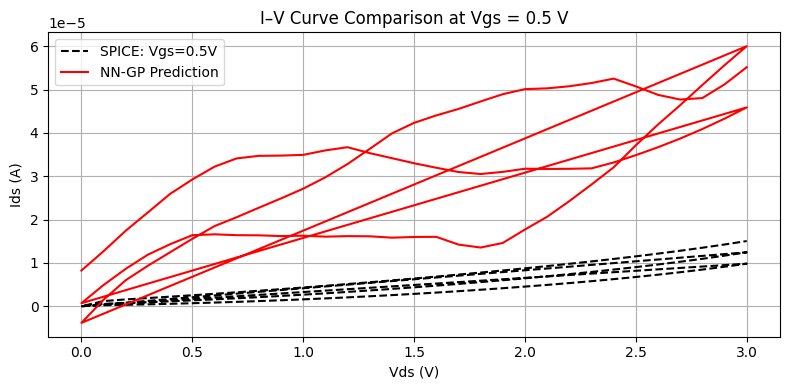

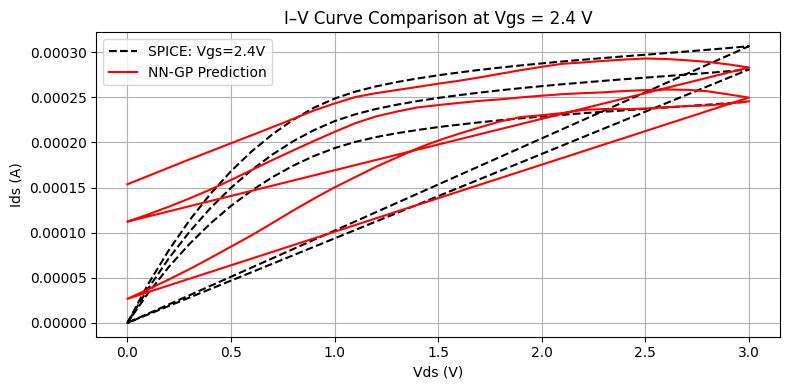

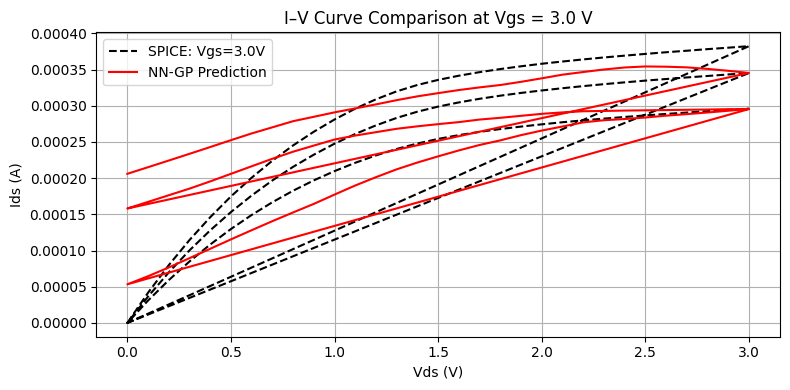

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel, WhiteKernel
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, KFold
from scipy.special import erf

# Load and preprocess dataset
file_path = '/content/nfet_120_40.CSV'
df = pd.read_csv(file_path)[['temp', 'V_gs', 'V_ds', 'I_ds']].dropna()
df.columns = ['temp', 'Vgs', 'Vds', 'Ids']

# Exclude Vgs = 0.5, 2.4, 3.0 from training
excluded_vgs = [0.5, 2.4, 3.0]
df_train = df[~df['Vgs'].isin(excluded_vgs)].copy()
X = df_train[['temp', 'Vgs', 'Vds']].values
y = df_train['Ids'].values.reshape(-1, 1)

# Initialize scalers
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Random initial training data
np.random.seed(42)
n_initial = 30
initial_indices = np.random.choice(len(X), size=n_initial, replace=False)
X_train, y_train = X[initial_indices], y[initial_indices]

# NN model setup
def create_nn_model(X, y):
    param_grid = {
        'hidden_layer_sizes': [(50,), (100,), (50, 30)],
        'alpha': [0.0001, 0.001],
        'learning_rate': ['constant', 'adaptive'],
        'max_iter': [2000]
    }
    cv = min(3, len(X))
    model = MLPRegressor(random_state=42, early_stopping=True)
    grid = GridSearchCV(model, param_grid, cv=cv, scoring='neg_mean_squared_error')
    Xs = scaler_X.fit_transform(X)
    ys = scaler_y.fit_transform(y)
    if len(X) >= 2 * cv:
        grid.fit(Xs, ys.ravel())
        return grid.best_estimator_
    else:
        model.set_params(hidden_layer_sizes=(50, 30), alpha=0.001, learning_rate='adaptive')
        model.fit(Xs, ys.ravel())
        return model

# GP model setup
def create_gp_model():
    kernel = ConstantKernel(1.0) * (RBF() + Matern(nu=1.5) + WhiteKernel())
    return GaussianProcessRegressor(kernel=kernel, alpha=1e-6, normalize_y=True, n_restarts_optimizer=5)

# Acquisition function
def acquisition_function(mean, std, best_y, xi=0.01):
    improvement = mean - best_y - xi
    z = improvement / (std + 1e-9)
    ei = improvement * (0.5 * (1 + erf(z / np.sqrt(2))))
    ei[std == 0] = 0.0
    return ei

# Active learning loop
iterations = 4
samples_per_iter = 10
for i in range(iterations):
    print(f"Hybrid NN-GP Iteration {i+1}/{iterations}")
    X_scaled = scaler_X.fit_transform(X_train)
    y_scaled = scaler_y.fit_transform(y_train)

    nn_model = create_nn_model(X_train, y_train)
    nn_model.fit(X_scaled, y_scaled.ravel())

    X_all_scaled = scaler_X.transform(X)
    y_nn_scaled = nn_model.predict(X_all_scaled).reshape(-1, 1)
    y_nn = scaler_y.inverse_transform(y_nn_scaled)

    # Train GP on residuals
    y_train_pred_scaled = nn_model.predict(X_scaled).reshape(-1, 1)
    y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
    residuals = y_train - y_train_pred
    gp_model = create_gp_model()
    gp_model.fit(X_train, residuals.ravel())

    gp_corr, gp_std = gp_model.predict(X, return_std=True)
    final_pred = y_nn + gp_corr.reshape(-1, 1)

    best_pred = np.max(y_nn)
    acq_values = acquisition_function(y_nn.ravel(), gp_std, best_pred)
    new_indices = np.argsort(acq_values)[-samples_per_iter:]
    X_new, y_new = X[new_indices], y[new_indices]
    X_train = np.vstack((X_train, X_new))
    y_train = np.vstack((y_train, y_new))

# --- Evaluation for Vgs = 0.5V, 2.4V, 3.0V ---
df_eval = df[df['Vgs'].isin(excluded_vgs)].copy()
X_eval = df_eval[['temp', 'Vgs', 'Vds']].values
y_eval = df_eval['Ids'].values.reshape(-1, 1)

# Predict
X_eval_scaled = scaler_X.transform(X_eval)
y_nn_scaled_eval = nn_model.predict(X_eval_scaled).reshape(-1, 1)
y_nn_eval = scaler_y.inverse_transform(y_nn_scaled_eval)
gp_corr_eval, _ = gp_model.predict(X_eval, return_std=True)
y_pred_eval = y_nn_eval + gp_corr_eval.reshape(-1, 1)

# Plot comparisons
excluded_vgs_sorted = sorted(set(excluded_vgs))
for vgs_val in excluded_vgs_sorted:
    subset = df_eval[df_eval['Vgs'] == vgs_val]
    y_true = subset['Ids'].values
    y_pred = y_pred_eval[df_eval['Vgs'] == vgs_val].flatten()

    plt.figure(figsize=(8, 4))
    plt.plot(subset['Vds'], y_true, 'k--', label=f'SPICE: Vgs={vgs_val}V')
    plt.plot(subset['Vds'], y_pred, 'r-', label='NN-GP Prediction')
    plt.xlabel('Vds (V)')
    plt.ylabel('Ids (A)')
    plt.title(f'I–V Curve Comparison at Vgs = {vgs_val} V')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


Hybrid NN-GP Iteration 1/4


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Hybrid NN-GP Iteration 2/4


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Hybrid NN-GP Iteration 3/4


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Hybrid NN-GP Iteration 4/4


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


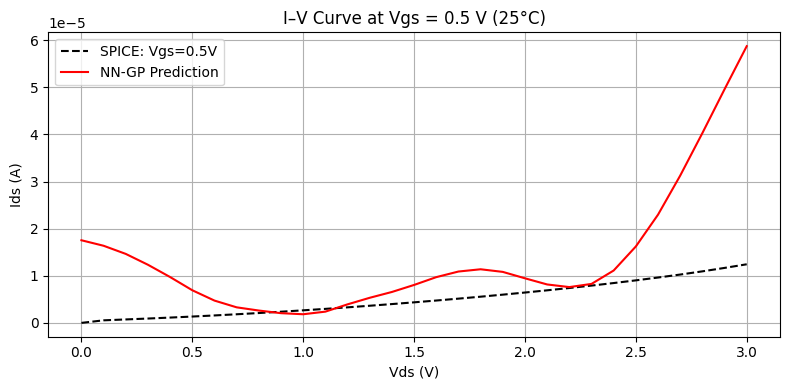

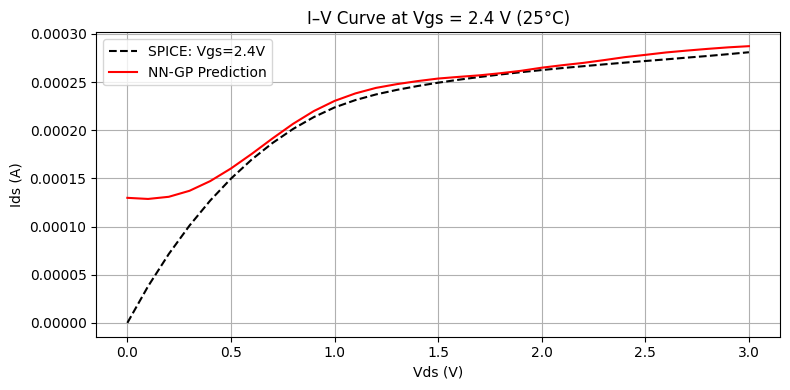

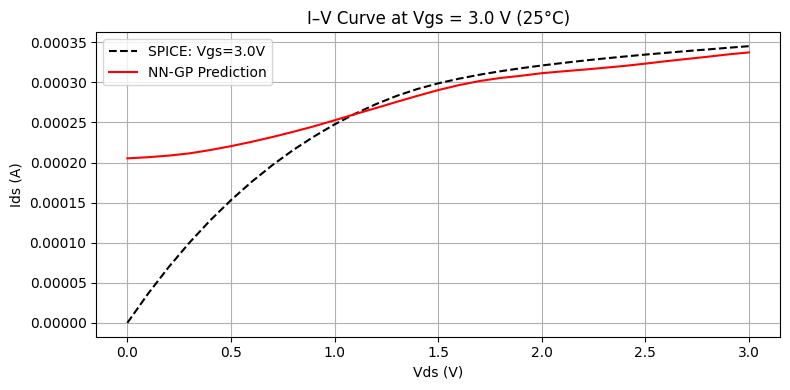

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel, WhiteKernel
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, KFold
from scipy.special import erf

# Load and preprocess dataset
file_path = '/content/nfet_120_40.CSV'
df = pd.read_csv(file_path)[['temp', 'V_gs', 'V_ds', 'I_ds']].dropna()
df.columns = ['temp', 'Vgs', 'Vds', 'Ids']

# Use only data at 25°C
df_25C = df[df['temp'] == 25].copy()

# Exclude Vgs = 0.5, 2.4, 3.0 from training
excluded_vgs = [0.5, 2.4, 3.0]
df_train = df_25C[~df_25C['Vgs'].isin(excluded_vgs)].copy()
X = df_train[['Vgs', 'Vds']].values
y = df_train['Ids'].values.reshape(-1, 1)

# Standardize
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Random initial subset
np.random.seed(42)
n_initial = 20
initial_indices = np.random.choice(len(X), size=n_initial, replace=False)
X_train, y_train = X[initial_indices], y[initial_indices]

# NN model
def create_nn_model(X, y):
    param_grid = {
        'hidden_layer_sizes': [(50,), (100,), (50, 30)],
        'alpha': [0.0001, 0.001],
        'learning_rate': ['constant', 'adaptive'],
        'max_iter': [2000]
    }
    cv = min(3, len(X))
    model = MLPRegressor(random_state=42, early_stopping=True)
    grid = GridSearchCV(model, param_grid, cv=cv, scoring='neg_mean_squared_error')
    Xs = scaler_X.fit_transform(X)
    ys = scaler_y.fit_transform(y)
    if len(X) >= 2 * cv:
        grid.fit(Xs, ys.ravel())
        return grid.best_estimator_
    else:
        model.set_params(hidden_layer_sizes=(50, 30), alpha=0.001, learning_rate='adaptive')
        model.fit(Xs, ys.ravel())
        return model

# GP model
def create_gp_model():
    kernel = ConstantKernel(1.0) * (RBF() + Matern(nu=1.5) + WhiteKernel())
    return GaussianProcessRegressor(kernel=kernel, alpha=1e-6, normalize_y=True, n_restarts_optimizer=5)

# Acquisition function
def acquisition_function(mean, std, best_y, xi=0.01):
    improvement = mean - best_y - xi
    z = improvement / (std + 1e-9)
    ei = improvement * (0.5 * (1 + erf(z / np.sqrt(2))))
    ei[std == 0] = 0.0
    return ei

# Active Learning Loop
iterations = 4
samples_per_iter = 10
for i in range(iterations):
    print(f"Hybrid NN-GP Iteration {i+1}/{iterations}")
    X_scaled = scaler_X.fit_transform(X_train)
    y_scaled = scaler_y.fit_transform(y_train)

    nn_model = create_nn_model(X_train, y_train)
    nn_model.fit(X_scaled, y_scaled.ravel())

    X_all_scaled = scaler_X.transform(X)
    y_nn_scaled = nn_model.predict(X_all_scaled).reshape(-1, 1)
    y_nn = scaler_y.inverse_transform(y_nn_scaled)

    y_train_pred_scaled = nn_model.predict(X_scaled).reshape(-1, 1)
    y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
    residuals = y_train - y_train_pred
    gp_model = create_gp_model()
    gp_model.fit(X_train, residuals.ravel())

    gp_corr, gp_std = gp_model.predict(X, return_std=True)
    final_pred = y_nn + gp_corr.reshape(-1, 1)

    best_pred = np.max(y_nn)
    acq_values = acquisition_function(y_nn.ravel(), gp_std, best_pred)
    new_indices = np.argsort(acq_values)[-samples_per_iter:]
    X_new, y_new = X[new_indices], y[new_indices]
    X_train = np.vstack((X_train, X_new))
    y_train = np.vstack((y_train, y_new))

# Evaluate on excluded Vgs values (at 25°C)
df_eval = df_25C[df_25C['Vgs'].isin(excluded_vgs)].copy()
X_eval = df_eval[['Vgs', 'Vds']].values
y_eval = df_eval['Ids'].values.reshape(-1, 1)

X_eval_scaled = scaler_X.transform(X_eval)
y_nn_scaled_eval = nn_model.predict(X_eval_scaled).reshape(-1, 1)
y_nn_eval = scaler_y.inverse_transform(y_nn_scaled_eval)
gp_corr_eval, _ = gp_model.predict(X_eval, return_std=True)
y_pred_eval = y_nn_eval + gp_corr_eval.reshape(-1, 1)

# Plot comparison
for vgs_val in sorted(set(excluded_vgs)):
    subset = df_eval[df_eval['Vgs'] == vgs_val]
    y_true = subset['Ids'].values
    y_pred = y_pred_eval[df_eval['Vgs'] == vgs_val].flatten()

    plt.figure(figsize=(8, 4))
    plt.plot(subset['Vds'], y_true, 'k--', label=f'SPICE: Vgs={vgs_val}V')
    plt.plot(subset['Vds'], y_pred, 'r-', label='NN-GP Prediction')
    plt.xlabel('Vds (V)')
    plt.ylabel('Ids (A)')
    plt.title(f'I–V Curve at Vgs = {vgs_val} V (25°C)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


Hybrid NN-GP Iteration 1/4


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Hybrid NN-GP Iteration 2/4
Hybrid NN-GP Iteration 3/4
Hybrid NN-GP Iteration 4/4


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


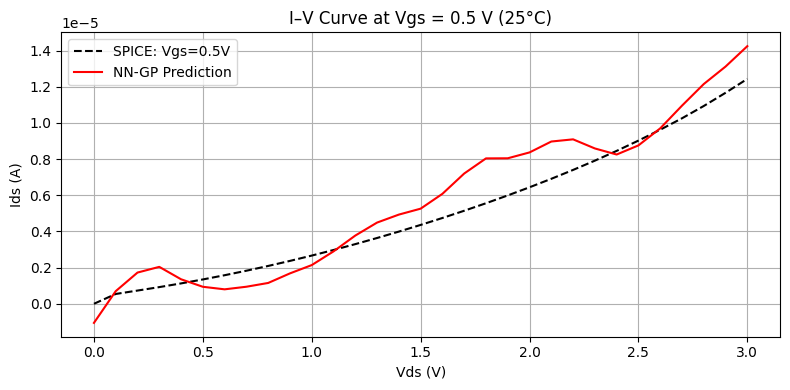

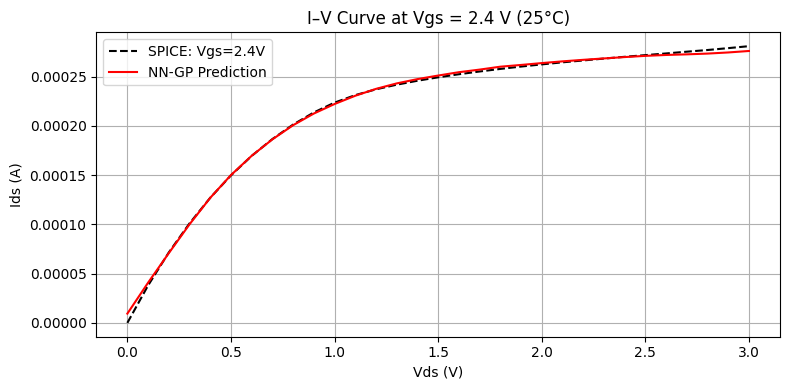

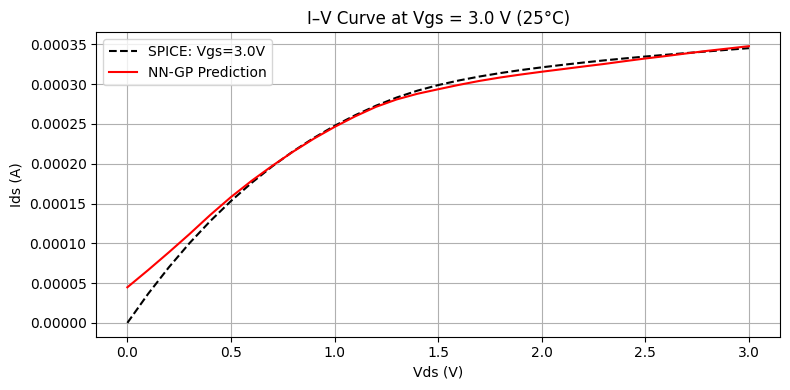

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel, WhiteKernel
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, KFold
from scipy.special import erf

# Load and filter for 25°C
df = pd.read_csv('/content/nfet_120_40.CSV')[['temp', 'V_gs', 'V_ds', 'I_ds']].dropna()
df.columns = ['temp', 'Vgs', 'Vds', 'Ids']
df_25C = df[df['temp'] == 25].copy()

# Exclude Vgs = 0.5, 2.4, 3.0
excluded_vgs = [0.5, 2.4, 3.0]
df_train = df_25C[~df_25C['Vgs'].isin(excluded_vgs)].copy()
X = df_train[['Vgs', 'Vds']].values
y = df_train['Ids'].values.reshape(-1, 1)

# Initialize scalers
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Initial training subset
np.random.seed(42)
n_initial = 30
initial_indices = np.random.choice(len(X), size=n_initial, replace=False)
X_train, y_train = X[initial_indices], y[initial_indices]

# Neural Network with improved architecture
def create_nn_model(X, y):
    param_grid = {
        'hidden_layer_sizes': [(100, 50), (80, 40), (100, 80, 40)],
        'alpha': [0.0001, 0.001],
        'learning_rate': ['constant', 'adaptive'],
        'max_iter': [5000]
    }
    cv = min(3, len(X))
    model = MLPRegressor(random_state=42, early_stopping=True)
    grid = GridSearchCV(model, param_grid, cv=cv, scoring='neg_mean_squared_error')
    Xs = scaler_X.fit_transform(X)
    ys = scaler_y.fit_transform(y)
    if len(X) >= 2 * cv:
        grid.fit(Xs, ys.ravel())
        return grid.best_estimator_
    else:
        model.set_params(hidden_layer_sizes=(100, 50), alpha=0.001, learning_rate='adaptive')
        model.fit(Xs, ys.ravel())
        return model

# Gaussian Process with enhanced kernel
def create_gp_model():
    kernel = ConstantKernel(1.0, (1e-2, 10)) * (RBF(1.0) + Matern(nu=1.5)) + WhiteKernel(noise_level=1e-5)
    return GaussianProcessRegressor(kernel=kernel, alpha=1e-6, normalize_y=True, n_restarts_optimizer=5)

# Acquisition function with diversity component
def acquisition_function(mean, std, best_y, X_pool, X_train, xi=0.01):
    improvement = mean - best_y - xi
    z = improvement / (std + 1e-9)
    ei = improvement * (0.5 * (1 + erf(z / np.sqrt(2))))
    ei[std == 0] = 0.0
    # Diversity term: distance to nearest training point
    distances = np.min(np.linalg.norm(X_pool[:, None] - X_train[None, :], axis=2), axis=1)
    norm_dist = distances / (np.max(distances) + 1e-10)
    return 0.7 * ei + 0.3 * norm_dist

# Active Learning Loop
iterations = 4
samples_per_iter = 10

for i in range(iterations):
    print(f"Hybrid NN-GP Iteration {i+1}/{iterations}")
    X_scaled = scaler_X.fit_transform(X_train)
    y_scaled = scaler_y.fit_transform(y_train)

    nn_model = create_nn_model(X_train, y_train)
    nn_model.fit(X_scaled, y_scaled.ravel())

    X_all_scaled = scaler_X.transform(X)
    y_nn_scaled = nn_model.predict(X_all_scaled).reshape(-1, 1)
    y_nn = scaler_y.inverse_transform(y_nn_scaled)

    y_train_pred_scaled = nn_model.predict(X_scaled).reshape(-1, 1)
    y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
    residuals = y_train - y_train_pred
    gp_model = create_gp_model()
    gp_model.fit(X_train, residuals.ravel())

    gp_corr, gp_std = gp_model.predict(X, return_std=True)
    final_pred = y_nn + gp_corr.reshape(-1, 1)

    best_pred = np.max(y_nn)
    acq_values = acquisition_function(y_nn.ravel(), gp_std, best_pred, X, X_train)
    new_indices = np.argsort(acq_values)[-samples_per_iter:]
    X_new, y_new = X[new_indices], y[new_indices]
    X_train = np.vstack((X_train, X_new))
    y_train = np.vstack((y_train, y_new))

# Evaluation for excluded Vgs
df_eval = df_25C[df_25C['Vgs'].isin(excluded_vgs)].copy()
X_eval = df_eval[['Vgs', 'Vds']].values
y_eval = df_eval['Ids'].values.reshape(-1, 1)

X_eval_scaled = scaler_X.transform(X_eval)
y_nn_scaled_eval = nn_model.predict(X_eval_scaled).reshape(-1, 1)
y_nn_eval = scaler_y.inverse_transform(y_nn_scaled_eval)
gp_corr_eval, _ = gp_model.predict(X_eval, return_std=True)
y_pred_eval = y_nn_eval + gp_corr_eval.reshape(-1, 1)

# Plot comparisons
for vgs_val in sorted(set(excluded_vgs)):
    subset = df_eval[df_eval['Vgs'] == vgs_val]
    y_true = subset['Ids'].values
    y_pred = y_pred_eval[df_eval['Vgs'] == vgs_val].flatten()

    plt.figure(figsize=(8, 4))
    plt.plot(subset['Vds'], y_true, 'k--', label=f'SPICE: Vgs={vgs_val}V')
    plt.plot(subset['Vds'], y_pred, 'r-', label='NN-GP Prediction')
    plt.xlabel('Vds (V)')
    plt.ylabel('Ids (A)')
    plt.title(f'I–V Curve at Vgs = {vgs_val} V (25°C)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


Hybrid NN-GP Iteration 1/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Hybrid NN-GP Iteration 2/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Hybrid NN-GP Iteration 3/6
Hybrid NN-GP Iteration 4/6
Hybrid NN-GP Iteration 5/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Hybrid NN-GP Iteration 6/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


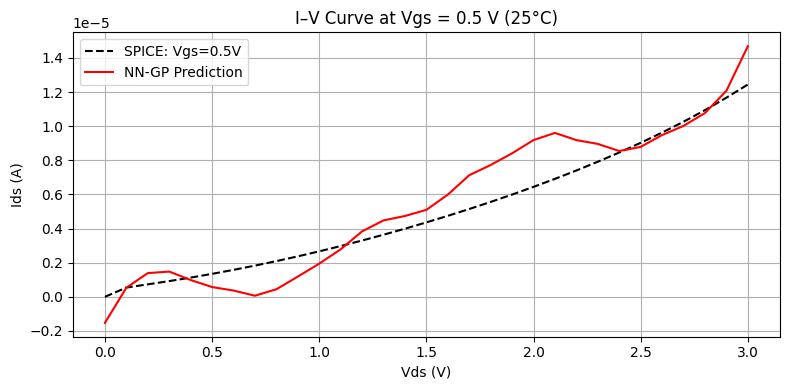

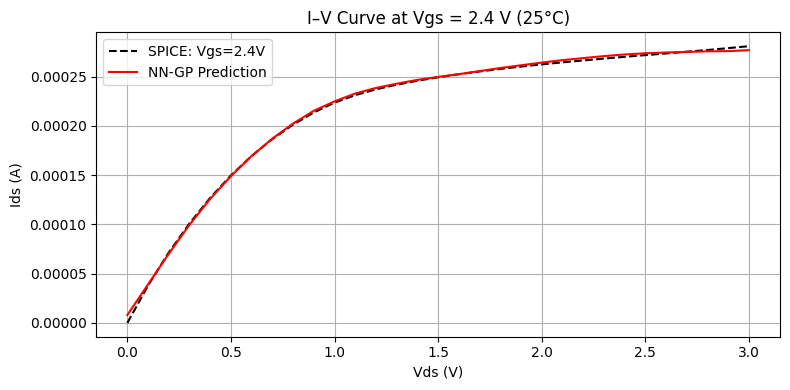

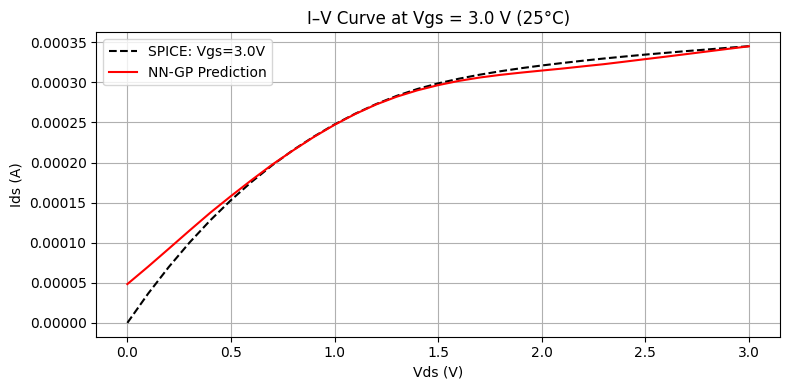

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic, ConstantKernel, WhiteKernel
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process.kernels import Matern
from scipy.special import erf

# Load and filter 25°C data
df = pd.read_csv('/content/nfet_120_40.CSV')[['temp', 'V_gs', 'V_ds', 'I_ds']].dropna()
df.columns = ['temp', 'Vgs', 'Vds', 'Ids']
df_25C = df[df['temp'] == 25].copy()
excluded_vgs = [0.5, 2.4, 3.0]
df_train = df_25C[~df_25C['Vgs'].isin(excluded_vgs)].copy()

X = df_train[['Vgs', 'Vds']].values
y = df_train['Ids'].values.reshape(-1, 1)

# Scalers
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Initial training subset
np.random.seed(42)
n_initial = 30
initial_indices = np.random.choice(len(X), size=n_initial, replace=False)
X_train, y_train = X[initial_indices], y[initial_indices]

# Neural Network with deeper architecture
def create_nn_model(X, y):
    param_grid = {
        'hidden_layer_sizes': [(100, 50), (80, 40), (100, 80, 40)],
        'alpha': [0.0001, 0.001],
        'learning_rate': ['constant', 'adaptive'],
        'max_iter': [5000]
    }
    model = MLPRegressor(random_state=42, early_stopping=True)
    grid = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error')
    Xs = scaler_X.fit_transform(X)
    ys = scaler_y.fit_transform(y)
    grid.fit(Xs, ys.ravel())
    return grid.best_estimator_

# Flexible GP kernel
def create_gp_model():
    kernel = ConstantKernel(1.0, (1e-2, 10)) * (RBF(1.0) + RationalQuadratic()) + WhiteKernel(noise_level=1e-5)
    return GaussianProcessRegressor(kernel=kernel, alpha=1e-6, normalize_y=True, n_restarts_optimizer=5)

# Acquisition function with diversity
def acquisition_function(mean, std, best_y, X_pool, X_train, xi=0.01):
    improvement = mean - best_y - xi
    z = improvement / (std + 1e-9)
    ei = improvement * (0.5 * (1 + erf(z / np.sqrt(2))))
    ei[std == 0] = 0.0
    distances = np.min(np.linalg.norm(X_pool[:, None] - X_train[None, :], axis=2), axis=1)
    norm_dist = distances / (np.max(distances) + 1e-10)
    return 0.7 * ei + 0.3 * norm_dist

# Active Learning Loop
iterations = 6
samples_per_iter = 5

for i in range(iterations):
    print(f"Hybrid NN-GP Iteration {i+1}/{iterations}")
    X_scaled = scaler_X.fit_transform(X_train)
    y_scaled = scaler_y.fit_transform(y_train)

    nn_model = create_nn_model(X_train, y_train)
    nn_model.fit(X_scaled, y_scaled.ravel())

    X_all_scaled = scaler_X.transform(X)
    y_nn_scaled = nn_model.predict(X_all_scaled).reshape(-1, 1)
    y_nn = scaler_y.inverse_transform(y_nn_scaled)

    y_train_pred_scaled = nn_model.predict(X_scaled).reshape(-1, 1)
    y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
    residuals = y_train - y_train_pred

    gp_model = create_gp_model()
    gp_model.fit(X_train, residuals.ravel())

    gp_corr, gp_std = gp_model.predict(X, return_std=True)
    final_pred = y_nn + gp_corr.reshape(-1, 1)

    best_pred = np.max(y_nn)
    acq_values = acquisition_function(y_nn.ravel(), gp_std, best_pred, X, X_train)
    new_indices = np.argsort(acq_values)[-samples_per_iter:]
    X_new, y_new = X[new_indices], y[new_indices]
    X_train = np.vstack((X_train, X_new))
    y_train = np.vstack((y_train, y_new))

# Evaluation on excluded Vgs values
df_eval = df_25C[df_25C['Vgs'].isin(excluded_vgs)].copy()
X_eval = df_eval[['Vgs', 'Vds']].values
y_eval = df_eval['Ids'].values.reshape(-1, 1)

X_eval_scaled = scaler_X.transform(X_eval)
y_nn_scaled_eval = nn_model.predict(X_eval_scaled).reshape(-1, 1)
y_nn_eval = scaler_y.inverse_transform(y_nn_scaled_eval)
gp_corr_eval, _ = gp_model.predict(X_eval, return_std=True)
y_pred_eval = y_nn_eval + gp_corr_eval.reshape(-1, 1)

# Plot I-V curve comparisons
for vgs_val in sorted(set(excluded_vgs)):
    subset = df_eval[df_eval['Vgs'] == vgs_val]
    y_true = subset['Ids'].values
    y_pred = y_pred_eval[df_eval['Vgs'] == vgs_val].flatten()

    plt.figure(figsize=(8, 4))
    plt.plot(subset['Vds'], y_true, 'k--', label=f'SPICE: Vgs={vgs_val}V')
    plt.plot(subset['Vds'], y_pred, 'r-', label='NN-GP Prediction')
    plt.xlabel('Vds (V)')
    plt.ylabel('Ids (A)')
    plt.title(f'I–V Curve at Vgs = {vgs_val} V (25°C)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


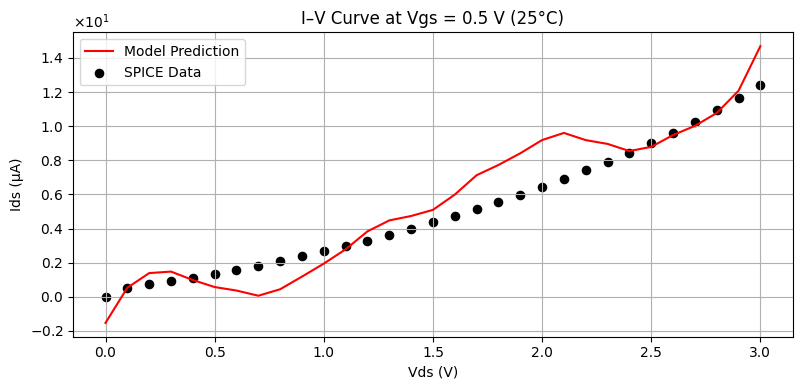

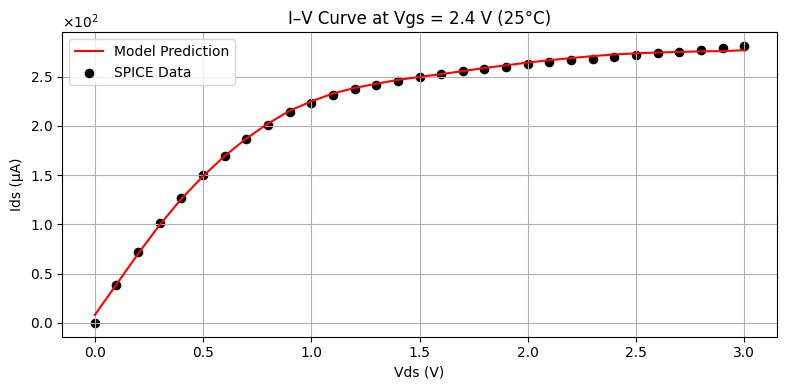

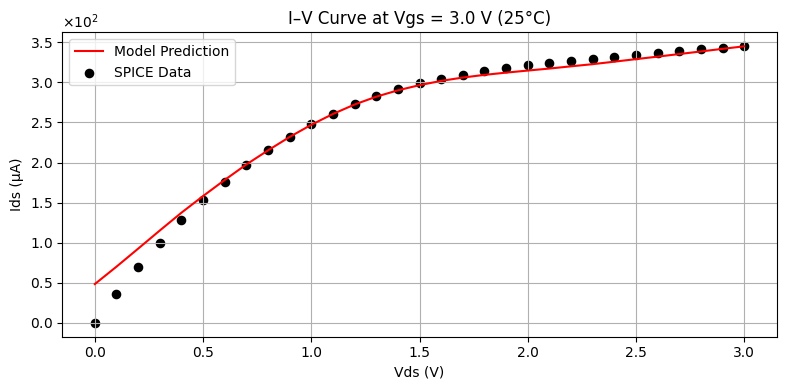

In [21]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Plot with SPICE scatter and adaptive Y-axis scaling
for vgs_val in sorted(set(excluded_vgs)):
    subset = df_eval[df_eval['Vgs'] == vgs_val]
    y_true = subset['Ids'].values
    y_pred = y_pred_eval[df_eval['Vgs'] == vgs_val].flatten()
    vds_vals = subset['Vds'].values

    # Decide scale: μA or mA
    max_current = max(np.max(y_true), np.max(y_pred))
    if max_current >= 1e-3:
        scale_factor = 1e3
        unit_label = 'mA'
    else:
        scale_factor = 1e6
        unit_label = 'μA'

    # Plot
    plt.figure(figsize=(8, 4))
    plt.plot(vds_vals, y_pred * scale_factor, 'r-', label='Model Prediction')
    plt.scatter(vds_vals, y_true * scale_factor, color='k', s=35, marker='o', label='SPICE Data')

    plt.xlabel('Vds (V)')
    plt.ylabel(f'Ids ({unit_label})')
    plt.title(f'I–V Curve at Vgs = {vgs_val} V (25°C)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    # Y-axis scientific notation if necessary
    ax = plt.gca()
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

    plt.show()


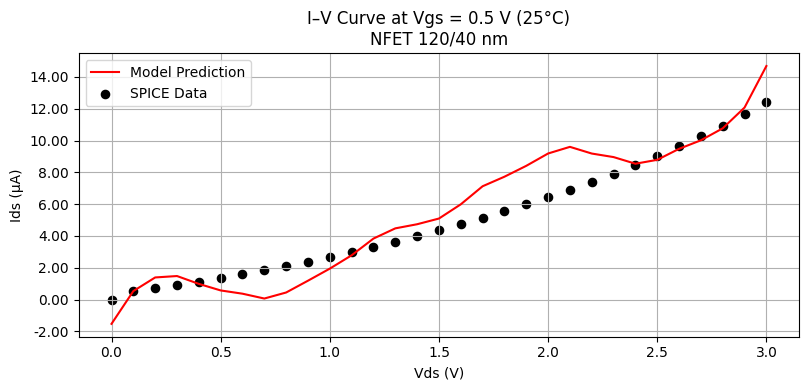

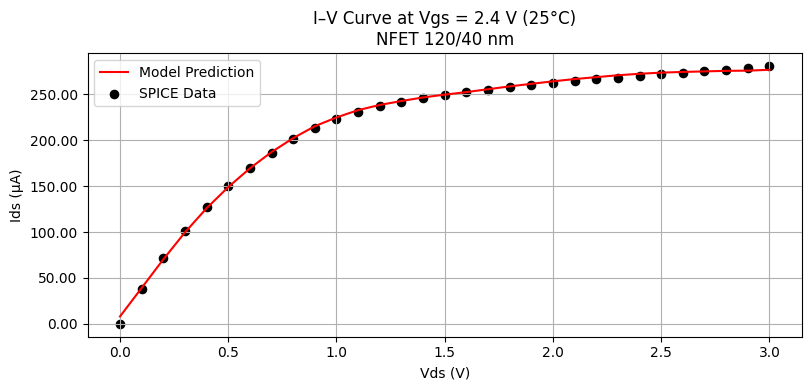

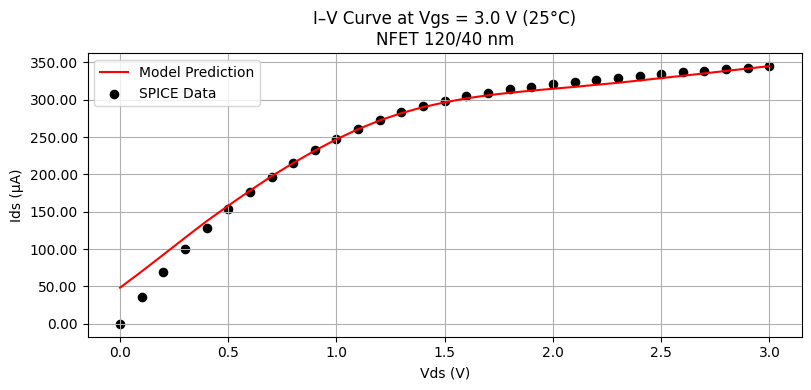

In [23]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Plot with SPICE scatter and adaptive Y-axis scaling
for vgs_val in sorted(set(excluded_vgs)):
    subset = df_eval[df_eval['Vgs'] == vgs_val]
    y_true = subset['Ids'].values
    y_pred = y_pred_eval[df_eval['Vgs'] == vgs_val].flatten()
    vds_vals = subset['Vds'].values

    # Decide scale: μA or mA
    max_current = max(np.max(y_true), np.max(y_pred))
    if max_current >= 1e-3:
        scale_factor = 1e3
        unit_label = 'mA'
    else:
        scale_factor = 1e6
        unit_label = 'μA'

    # Plot
    plt.figure(figsize=(8, 4))
    plt.plot(vds_vals, y_pred * scale_factor, 'r-', label='Model Prediction')
    plt.scatter(vds_vals, y_true * scale_factor, color='k', s=35, marker='o', label='SPICE Data')

    plt.xlabel('Vds (V)')
    plt.ylabel(f'Ids ({unit_label})')
    plt.title(f'I–V Curve at Vgs = {vgs_val} V (25°C)\nNFET 120/40 nm')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    # Format Y-axis ticks to plain numbers (no scientific notation)
    ax = plt.gca()
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:.2f}'))

    plt.show()


Iteration 1/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration 2/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration 3/6
Iteration 4/6
Iteration 5/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration 6/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


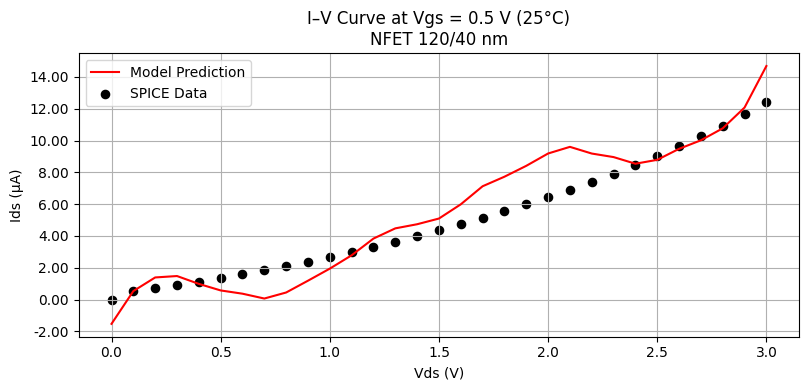

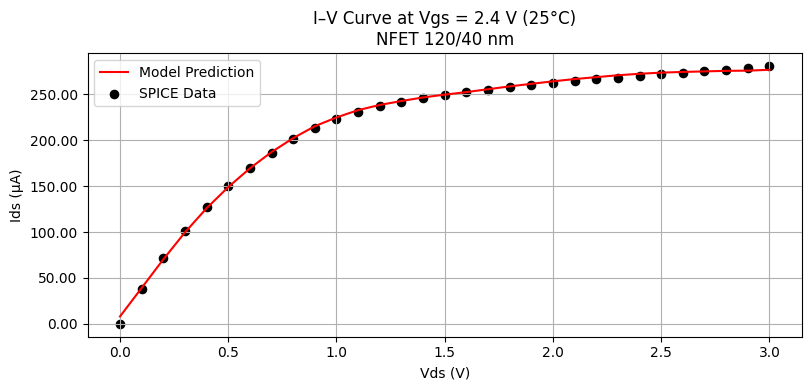

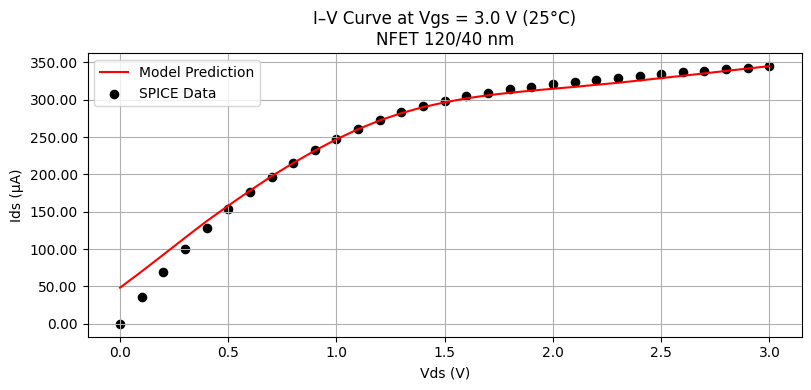

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic, ConstantKernel, WhiteKernel
from sklearn.model_selection import GridSearchCV
from scipy.special import erf

# Load and filter 25°C data
df = pd.read_csv('/content/nfet_120_40.CSV')[['temp', 'V_gs', 'V_ds', 'I_ds']].dropna()
df.columns = ['temp', 'Vgs', 'Vds', 'Ids']
df_25C = df[df['temp'] == 25].copy()

# Exclude Vgs = 0.5, 2.4, 3.0
excluded_vgs = [0.5, 2.4, 3.0]
df_train = df_25C[~df_25C['Vgs'].isin(excluded_vgs)].copy()
X = df_train[['Vgs', 'Vds']].values
y = df_train['Ids'].values.reshape(-1, 1)

# Standardization
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Initial training points
np.random.seed(42)
initial_indices = np.random.choice(len(X), size=30, replace=False)
X_train = X[initial_indices]
y_train = y[initial_indices]

# NN model
def create_nn_model(X, y):
    param_grid = {
        'hidden_layer_sizes': [(100, 50), (80, 40), (100, 80, 40)],
        'alpha': [0.0001, 0.001],
        'learning_rate': ['constant', 'adaptive'],
        'max_iter': [5000]
    }
    model = MLPRegressor(random_state=42, early_stopping=True)
    grid = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error')
    Xs = scaler_X.fit_transform(X)
    ys = scaler_y.fit_transform(y)
    grid.fit(Xs, ys.ravel())
    return grid.best_estimator_

# GP model
def create_gp_model():
    kernel = ConstantKernel(1.0, (1e-2, 10)) * (RBF(1.0) + RationalQuadratic()) + WhiteKernel(noise_level=1e-5)
    return GaussianProcessRegressor(kernel=kernel, alpha=1e-6, normalize_y=True, n_restarts_optimizer=5)

# Acquisition function
def acquisition_function(mean, std, best_y, X_pool, X_train, xi=0.01):
    improvement = mean - best_y - xi
    z = improvement / (std + 1e-9)
    ei = improvement * (0.5 * (1 + erf(z / np.sqrt(2))))
    ei[std == 0] = 0.0
    distances = np.min(np.linalg.norm(X_pool[:, None] - X_train[None, :], axis=2), axis=1)
    norm_dist = distances / (np.max(distances) + 1e-10)
    return 0.7 * ei + 0.3 * norm_dist

# Active learning
for i in range(6):
    print(f"Iteration {i+1}/6")
    X_scaled = scaler_X.fit_transform(X_train)
    y_scaled = scaler_y.fit_transform(y_train)

    nn_model = create_nn_model(X_train, y_train)
    nn_model.fit(X_scaled, y_scaled.ravel())

    X_all_scaled = scaler_X.transform(X)
    y_nn_scaled = nn_model.predict(X_all_scaled).reshape(-1, 1)
    y_nn = scaler_y.inverse_transform(y_nn_scaled)

    y_train_pred_scaled = nn_model.predict(X_scaled).reshape(-1, 1)
    y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
    residuals = y_train - y_train_pred

    gp_model = create_gp_model()
    gp_model.fit(X_train, residuals.ravel())

    gp_corr, gp_std = gp_model.predict(X, return_std=True)
    final_pred = y_nn + gp_corr.reshape(-1, 1)

    best_pred = np.max(y_nn)
    acq_values = acquisition_function(y_nn.ravel(), gp_std, best_pred, X, X_train)
    new_indices = np.argsort(acq_values)[-5:]
    X_new = X[new_indices]
    y_new = y[new_indices]
    X_train = np.vstack((X_train, X_new))
    y_train = np.vstack((y_train, y_new))

# Evaluation
df_eval = df_25C[df_25C['Vgs'].isin(excluded_vgs)].copy()
X_eval = df_eval[['Vgs', 'Vds']].values
y_eval = df_eval['Ids'].values.reshape(-1, 1)

X_eval_scaled = scaler_X.transform(X_eval)
y_nn_scaled_eval = nn_model.predict(X_eval_scaled).reshape(-1, 1)
y_nn_eval = scaler_y.inverse_transform(y_nn_scaled_eval)
gp_corr_eval, _ = gp_model.predict(X_eval, return_std=True)
y_pred_eval = y_nn_eval + gp_corr_eval.reshape(-1, 1)

# Plotting
for vgs_val in sorted(set(excluded_vgs)):
    subset = df_eval[df_eval['Vgs'] == vgs_val]
    y_true = subset['Ids'].values
    y_pred = y_pred_eval[df_eval['Vgs'] == vgs_val].flatten()
    vds_vals = subset['Vds'].values

    max_current = max(np.max(y_true), np.max(y_pred))
    if max_current >= 1e-3:
        scale_factor = 1e3
        unit_label = 'mA'
    else:
        scale_factor = 1e6
        unit_label = 'μA'

    plt.figure(figsize=(8, 4))
    plt.plot(vds_vals, y_pred * scale_factor, 'r-', label='Model Prediction')
    plt.scatter(vds_vals, y_true * scale_factor, color='k', s=35, marker='o', label='SPICE Data')
    plt.xlabel('Vds (V)')
    plt.ylabel(f'Ids ({unit_label})')
    plt.title(f'I–V Curve at Vgs = {vgs_val} V (25°C)\nNFET 120/40 nm')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    ax = plt.gca()
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:.2f}'))
    plt.show()


Iteration 1/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration 2/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration 3/6
Iteration 4/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Iteration 5/6
Iteration 6/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


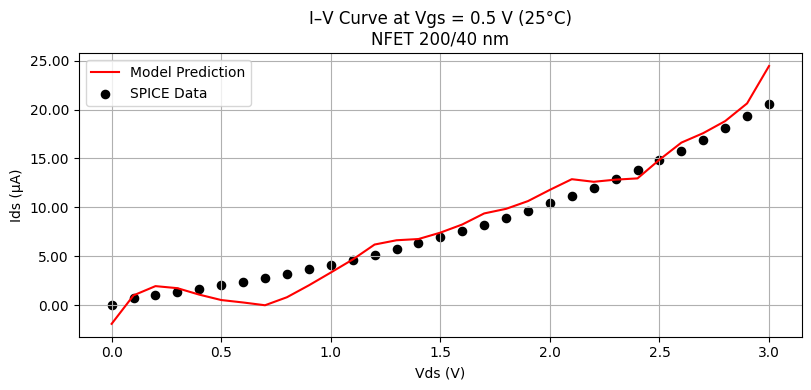

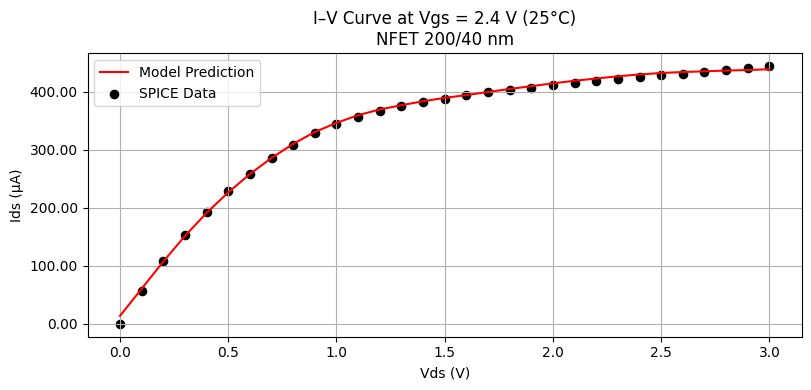

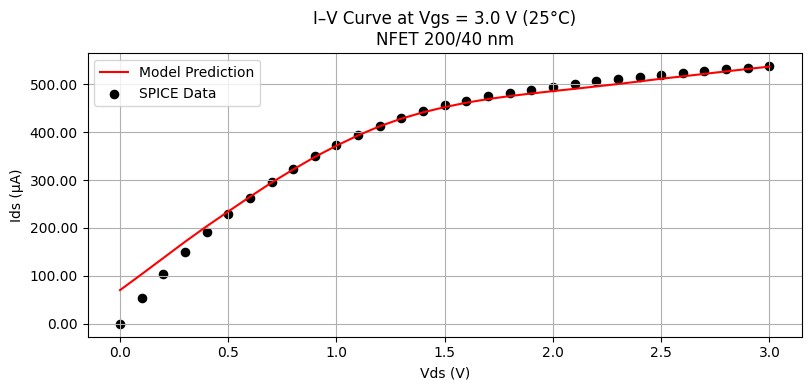

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic, ConstantKernel, WhiteKernel
from sklearn.model_selection import GridSearchCV
from scipy.special import erf

# Load and filter 25°C data
df = pd.read_csv('/content/nfet_200_40.CSV')[['temp', 'V_gs', 'V_ds', 'I_ds']].dropna()
df.columns = ['temp', 'Vgs', 'Vds', 'Ids']
df_25C = df[df['temp'] == 25].copy()

# Exclude Vgs = 0.5, 2.4, 3.0
excluded_vgs = [0.5, 2.4, 3.0]
df_train = df_25C[~df_25C['Vgs'].isin(excluded_vgs)].copy()
X = df_train[['Vgs', 'Vds']].values
y = df_train['Ids'].values.reshape(-1, 1)

# Standardization
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Initial training points
np.random.seed(42)
initial_indices = np.random.choice(len(X), size=30, replace=False)
X_train = X[initial_indices]
y_train = y[initial_indices]

# NN model
def create_nn_model(X, y):
    param_grid = {
        'hidden_layer_sizes': [(100, 50), (80, 40), (100, 80, 40)],
        'alpha': [0.0001, 0.001],
        'learning_rate': ['constant', 'adaptive'],
        'max_iter': [5000]
    }
    model = MLPRegressor(random_state=42, early_stopping=True)
    grid = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error')
    Xs = scaler_X.fit_transform(X)
    ys = scaler_y.fit_transform(y)
    grid.fit(Xs, ys.ravel())
    return grid.best_estimator_

# GP model
def create_gp_model():
    kernel = ConstantKernel(1.0, (1e-2, 10)) * (RBF(1.0) + RationalQuadratic()) + WhiteKernel(noise_level=1e-5)
    return GaussianProcessRegressor(kernel=kernel, alpha=1e-6, normalize_y=True, n_restarts_optimizer=5)

# Acquisition function
def acquisition_function(mean, std, best_y, X_pool, X_train, xi=0.01):
    improvement = mean - best_y - xi
    z = improvement / (std + 1e-9)
    ei = improvement * (0.5 * (1 + erf(z / np.sqrt(2))))
    ei[std == 0] = 0.0
    distances = np.min(np.linalg.norm(X_pool[:, None] - X_train[None, :], axis=2), axis=1)
    norm_dist = distances / (np.max(distances) + 1e-10)
    return 0.7 * ei + 0.3 * norm_dist

# Active learning
for i in range(6):
    print(f"Iteration {i+1}/6")
    X_scaled = scaler_X.fit_transform(X_train)
    y_scaled = scaler_y.fit_transform(y_train)

    nn_model = create_nn_model(X_train, y_train)
    nn_model.fit(X_scaled, y_scaled.ravel())

    X_all_scaled = scaler_X.transform(X)
    y_nn_scaled = nn_model.predict(X_all_scaled).reshape(-1, 1)
    y_nn = scaler_y.inverse_transform(y_nn_scaled)

    y_train_pred_scaled = nn_model.predict(X_scaled).reshape(-1, 1)
    y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
    residuals = y_train - y_train_pred

    gp_model = create_gp_model()
    gp_model.fit(X_train, residuals.ravel())

    gp_corr, gp_std = gp_model.predict(X, return_std=True)
    final_pred = y_nn + gp_corr.reshape(-1, 1)

    best_pred = np.max(y_nn)
    acq_values = acquisition_function(y_nn.ravel(), gp_std, best_pred, X, X_train)
    new_indices = np.argsort(acq_values)[-5:]
    X_new = X[new_indices]
    y_new = y[new_indices]
    X_train = np.vstack((X_train, X_new))
    y_train = np.vstack((y_train, y_new))

# Evaluation
df_eval = df_25C[df_25C['Vgs'].isin(excluded_vgs)].copy()
X_eval = df_eval[['Vgs', 'Vds']].values
y_eval = df_eval['Ids'].values.reshape(-1, 1)

X_eval_scaled = scaler_X.transform(X_eval)
y_nn_scaled_eval = nn_model.predict(X_eval_scaled).reshape(-1, 1)
y_nn_eval = scaler_y.inverse_transform(y_nn_scaled_eval)
gp_corr_eval, _ = gp_model.predict(X_eval, return_std=True)
y_pred_eval = y_nn_eval + gp_corr_eval.reshape(-1, 1)

# Plotting
for vgs_val in sorted(set(excluded_vgs)):
    subset = df_eval[df_eval['Vgs'] == vgs_val]
    y_true = subset['Ids'].values
    y_pred = y_pred_eval[df_eval['Vgs'] == vgs_val].flatten()
    vds_vals = subset['Vds'].values

    max_current = max(np.max(y_true), np.max(y_pred))
    if max_current >= 1e-3:
        scale_factor = 1e3
        unit_label = 'mA'
    else:
        scale_factor = 1e6
        unit_label = 'μA'

    plt.figure(figsize=(8, 4))
    plt.plot(vds_vals, y_pred * scale_factor, 'r-', label='Model Prediction')
    plt.scatter(vds_vals, y_true * scale_factor, color='k', s=35, marker='o', label='SPICE Data')
    plt.xlabel('Vds (V)')
    plt.ylabel(f'Ids ({unit_label})')
    plt.title(f'I–V Curve at Vgs = {vgs_val} V (25°C)\nNFET 200/40 nm')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    ax = plt.gca()
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:.2f}'))
    plt.show()


Iteration 1/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration 2/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration 3/6
Iteration 4/6
Iteration 5/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration 6/6


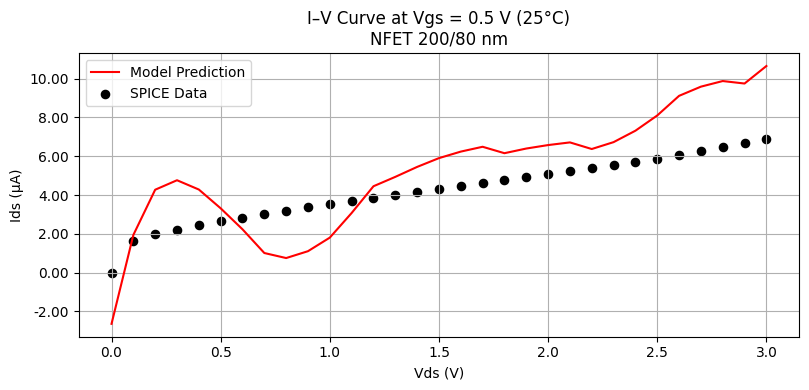

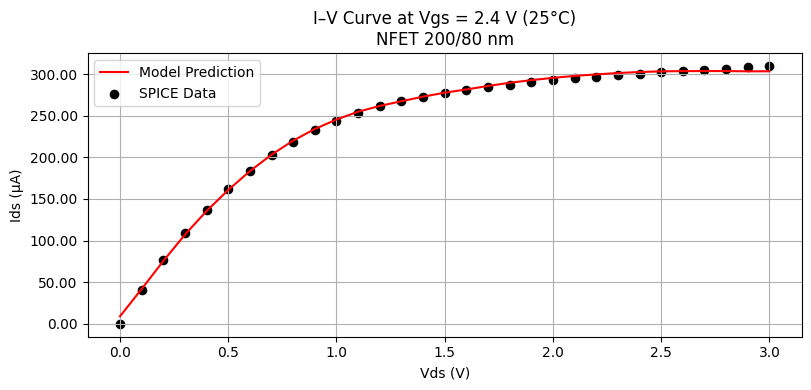

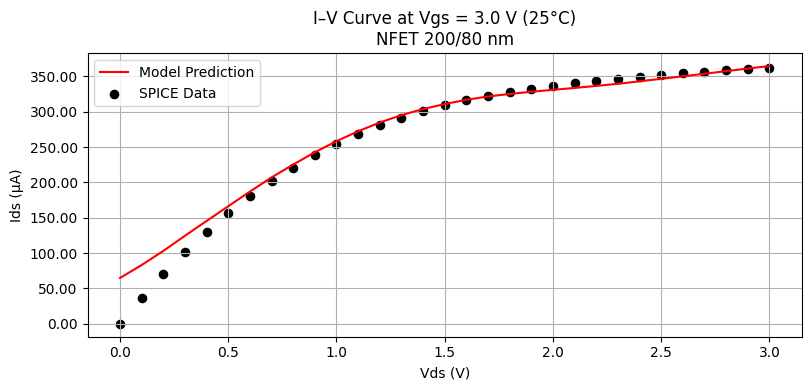

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic, ConstantKernel, WhiteKernel
from sklearn.model_selection import GridSearchCV
from scipy.special import erf

# Load and filter 25°C data
df = pd.read_csv('/content/nfet_200_80.CSV')[['temp', 'V_gs', 'V_ds', 'I_ds']].dropna()
df.columns = ['temp', 'Vgs', 'Vds', 'Ids']
df_25C = df[df['temp'] == 25].copy()

# Exclude Vgs = 0.5, 2.4, 3.0
excluded_vgs = [0.5, 2.4, 3.0]
df_train = df_25C[~df_25C['Vgs'].isin(excluded_vgs)].copy()
X = df_train[['Vgs', 'Vds']].values
y = df_train['Ids'].values.reshape(-1, 1)

# Standardization
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Initial training points
np.random.seed(42)
initial_indices = np.random.choice(len(X), size=30, replace=False)
X_train = X[initial_indices]
y_train = y[initial_indices]

# NN model
def create_nn_model(X, y):
    param_grid = {
        'hidden_layer_sizes': [(100, 50), (80, 40), (100, 80, 40)],
        'alpha': [0.0001, 0.001],
        'learning_rate': ['constant', 'adaptive'],
        'max_iter': [5000]
    }
    model = MLPRegressor(random_state=42, early_stopping=True)
    grid = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error')
    Xs = scaler_X.fit_transform(X)
    ys = scaler_y.fit_transform(y)
    grid.fit(Xs, ys.ravel())
    return grid.best_estimator_

# GP model
def create_gp_model():
    kernel = ConstantKernel(1.0, (1e-2, 10)) * (RBF(1.0) + RationalQuadratic()) + WhiteKernel(noise_level=1e-5)
    return GaussianProcessRegressor(kernel=kernel, alpha=1e-6, normalize_y=True, n_restarts_optimizer=5)

# Acquisition function
def acquisition_function(mean, std, best_y, X_pool, X_train, xi=0.01):
    improvement = mean - best_y - xi
    z = improvement / (std + 1e-9)
    ei = improvement * (0.5 * (1 + erf(z / np.sqrt(2))))
    ei[std == 0] = 0.0
    distances = np.min(np.linalg.norm(X_pool[:, None] - X_train[None, :], axis=2), axis=1)
    norm_dist = distances / (np.max(distances) + 1e-10)
    return 0.7 * ei + 0.3 * norm_dist

# Active learning
for i in range(6):
    print(f"Iteration {i+1}/6")
    X_scaled = scaler_X.fit_transform(X_train)
    y_scaled = scaler_y.fit_transform(y_train)

    nn_model = create_nn_model(X_train, y_train)
    nn_model.fit(X_scaled, y_scaled.ravel())

    X_all_scaled = scaler_X.transform(X)
    y_nn_scaled = nn_model.predict(X_all_scaled).reshape(-1, 1)
    y_nn = scaler_y.inverse_transform(y_nn_scaled)

    y_train_pred_scaled = nn_model.predict(X_scaled).reshape(-1, 1)
    y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
    residuals = y_train - y_train_pred

    gp_model = create_gp_model()
    gp_model.fit(X_train, residuals.ravel())

    gp_corr, gp_std = gp_model.predict(X, return_std=True)
    final_pred = y_nn + gp_corr.reshape(-1, 1)

    best_pred = np.max(y_nn)
    acq_values = acquisition_function(y_nn.ravel(), gp_std, best_pred, X, X_train)
    new_indices = np.argsort(acq_values)[-5:]
    X_new = X[new_indices]
    y_new = y[new_indices]
    X_train = np.vstack((X_train, X_new))
    y_train = np.vstack((y_train, y_new))

# Evaluation
df_eval = df_25C[df_25C['Vgs'].isin(excluded_vgs)].copy()
X_eval = df_eval[['Vgs', 'Vds']].values
y_eval = df_eval['Ids'].values.reshape(-1, 1)

X_eval_scaled = scaler_X.transform(X_eval)
y_nn_scaled_eval = nn_model.predict(X_eval_scaled).reshape(-1, 1)
y_nn_eval = scaler_y.inverse_transform(y_nn_scaled_eval)
gp_corr_eval, _ = gp_model.predict(X_eval, return_std=True)
y_pred_eval = y_nn_eval + gp_corr_eval.reshape(-1, 1)

# Plotting
for vgs_val in sorted(set(excluded_vgs)):
    subset = df_eval[df_eval['Vgs'] == vgs_val]
    y_true = subset['Ids'].values
    y_pred = y_pred_eval[df_eval['Vgs'] == vgs_val].flatten()
    vds_vals = subset['Vds'].values

    max_current = max(np.max(y_true), np.max(y_pred))
    if max_current >= 1e-3:
        scale_factor = 1e3
        unit_label = 'mA'
    else:
        scale_factor = 1e6
        unit_label = 'μA'

    plt.figure(figsize=(8, 4))
    plt.plot(vds_vals, y_pred * scale_factor, 'r-', label='Model Prediction')
    plt.scatter(vds_vals, y_true * scale_factor, color='k', s=35, marker='o', label='SPICE Data')
    plt.xlabel('Vds (V)')
    plt.ylabel(f'Ids ({unit_label})')
    plt.title(f'I–V Curve at Vgs = {vgs_val} V (25°C)\nNFET 200/80 nm')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    ax = plt.gca()
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:.2f}'))
    plt.show()


Iteration 1/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration 2/6
Iteration 3/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration 4/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration 5/6
Iteration 6/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


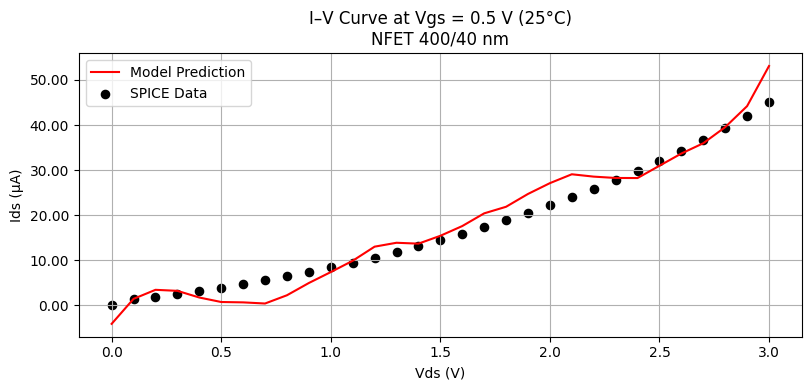

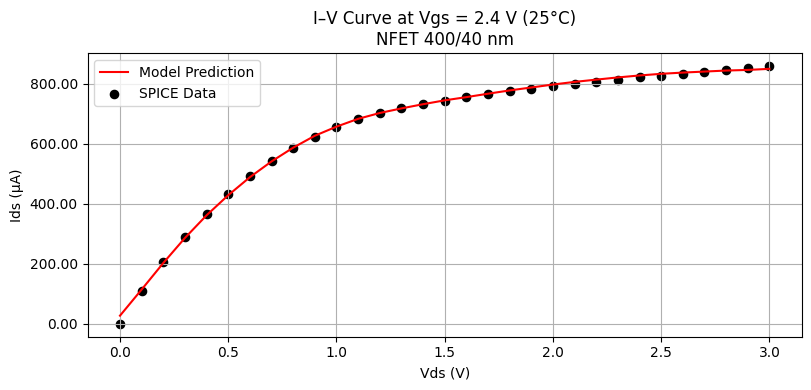

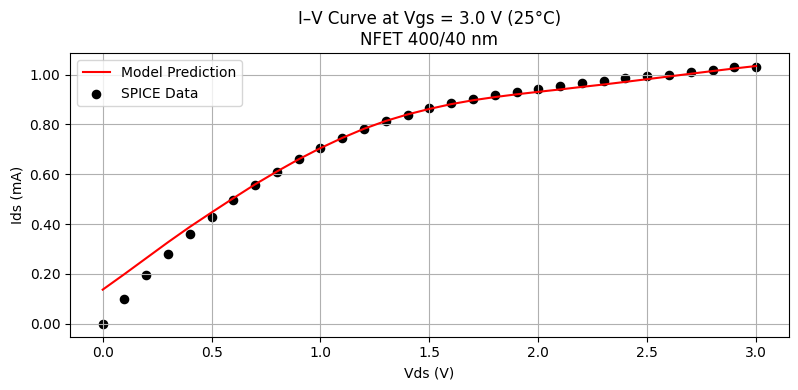

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic, ConstantKernel, WhiteKernel
from sklearn.model_selection import GridSearchCV
from scipy.special import erf

# Load and filter 25°C data
df = pd.read_csv('/content/nfet_400_40.CSV')[['temp', 'V_gs', 'V_ds', 'I_ds']].dropna()
df.columns = ['temp', 'Vgs', 'Vds', 'Ids']
df_25C = df[df['temp'] == 25].copy()

# Exclude Vgs = 0.5, 2.4, 3.0
excluded_vgs = [0.5, 2.4, 3.0]
df_train = df_25C[~df_25C['Vgs'].isin(excluded_vgs)].copy()
X = df_train[['Vgs', 'Vds']].values
y = df_train['Ids'].values.reshape(-1, 1)

# Standardization
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Initial training points
np.random.seed(42)
initial_indices = np.random.choice(len(X), size=30, replace=False)
X_train = X[initial_indices]
y_train = y[initial_indices]

# NN model
def create_nn_model(X, y):
    param_grid = {
        'hidden_layer_sizes': [(100, 50), (80, 40), (100, 80, 40)],
        'alpha': [0.0001, 0.001],
        'learning_rate': ['constant', 'adaptive'],
        'max_iter': [5000]
    }
    model = MLPRegressor(random_state=42, early_stopping=True)
    grid = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error')
    Xs = scaler_X.fit_transform(X)
    ys = scaler_y.fit_transform(y)
    grid.fit(Xs, ys.ravel())
    return grid.best_estimator_

# GP model
def create_gp_model():
    kernel = ConstantKernel(1.0, (1e-2, 10)) * (RBF(1.0) + RationalQuadratic()) + WhiteKernel(noise_level=1e-5)
    return GaussianProcessRegressor(kernel=kernel, alpha=1e-6, normalize_y=True, n_restarts_optimizer=5)

# Acquisition function
def acquisition_function(mean, std, best_y, X_pool, X_train, xi=0.01):
    improvement = mean - best_y - xi
    z = improvement / (std + 1e-9)
    ei = improvement * (0.5 * (1 + erf(z / np.sqrt(2))))
    ei[std == 0] = 0.0
    distances = np.min(np.linalg.norm(X_pool[:, None] - X_train[None, :], axis=2), axis=1)
    norm_dist = distances / (np.max(distances) + 1e-10)
    return 0.7 * ei + 0.3 * norm_dist

# Active learning
for i in range(6):
    print(f"Iteration {i+1}/6")
    X_scaled = scaler_X.fit_transform(X_train)
    y_scaled = scaler_y.fit_transform(y_train)

    nn_model = create_nn_model(X_train, y_train)
    nn_model.fit(X_scaled, y_scaled.ravel())

    X_all_scaled = scaler_X.transform(X)
    y_nn_scaled = nn_model.predict(X_all_scaled).reshape(-1, 1)
    y_nn = scaler_y.inverse_transform(y_nn_scaled)

    y_train_pred_scaled = nn_model.predict(X_scaled).reshape(-1, 1)
    y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
    residuals = y_train - y_train_pred

    gp_model = create_gp_model()
    gp_model.fit(X_train, residuals.ravel())

    gp_corr, gp_std = gp_model.predict(X, return_std=True)
    final_pred = y_nn + gp_corr.reshape(-1, 1)

    best_pred = np.max(y_nn)
    acq_values = acquisition_function(y_nn.ravel(), gp_std, best_pred, X, X_train)
    new_indices = np.argsort(acq_values)[-5:]
    X_new = X[new_indices]
    y_new = y[new_indices]
    X_train = np.vstack((X_train, X_new))
    y_train = np.vstack((y_train, y_new))

# Evaluation
df_eval = df_25C[df_25C['Vgs'].isin(excluded_vgs)].copy()
X_eval = df_eval[['Vgs', 'Vds']].values
y_eval = df_eval['Ids'].values.reshape(-1, 1)

X_eval_scaled = scaler_X.transform(X_eval)
y_nn_scaled_eval = nn_model.predict(X_eval_scaled).reshape(-1, 1)
y_nn_eval = scaler_y.inverse_transform(y_nn_scaled_eval)
gp_corr_eval, _ = gp_model.predict(X_eval, return_std=True)
y_pred_eval = y_nn_eval + gp_corr_eval.reshape(-1, 1)

# Plotting
for vgs_val in sorted(set(excluded_vgs)):
    subset = df_eval[df_eval['Vgs'] == vgs_val]
    y_true = subset['Ids'].values
    y_pred = y_pred_eval[df_eval['Vgs'] == vgs_val].flatten()
    vds_vals = subset['Vds'].values

    max_current = max(np.max(y_true), np.max(y_pred))
    if max_current >= 1e-3:
        scale_factor = 1e3
        unit_label = 'mA'
    else:
        scale_factor = 1e6
        unit_label = 'μA'

    plt.figure(figsize=(8, 4))
    plt.plot(vds_vals, y_pred * scale_factor, 'r-', label='Model Prediction')
    plt.scatter(vds_vals, y_true * scale_factor, color='k', s=35, marker='o', label='SPICE Data')
    plt.xlabel('Vds (V)')
    plt.ylabel(f'Ids ({unit_label})')
    plt.title(f'I–V Curve at Vgs = {vgs_val} V (25°C)\nNFET 400/40 nm')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    ax = plt.gca()
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:.2f}'))
    plt.show()


Iteration 1/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration 2/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration 3/6
Iteration 4/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration 5/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration 6/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


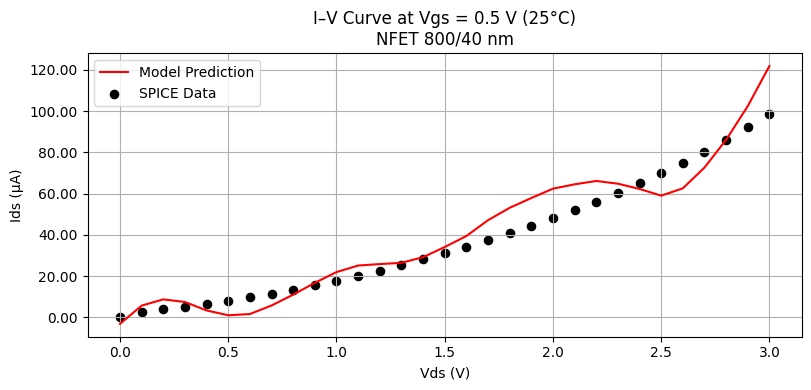

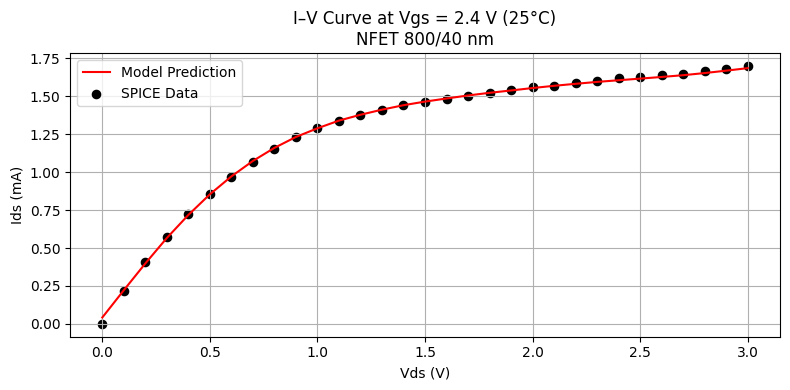

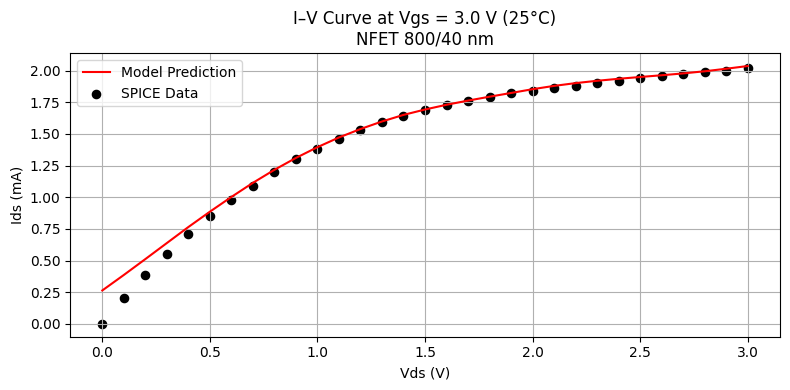

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic, ConstantKernel, WhiteKernel
from sklearn.model_selection import GridSearchCV
from scipy.special import erf

# Load and filter 25°C data
df = pd.read_csv('/content/nfet_800_40.CSV')[['temp', 'V_gs', 'V_ds', 'I_ds']].dropna()
df.columns = ['temp', 'Vgs', 'Vds', 'Ids']
df_25C = df[df['temp'] == 25].copy()

# Exclude Vgs = 0.5, 2.4, 3.0
excluded_vgs = [0.5, 2.4, 3.0]
df_train = df_25C[~df_25C['Vgs'].isin(excluded_vgs)].copy()
X = df_train[['Vgs', 'Vds']].values
y = df_train['Ids'].values.reshape(-1, 1)

# Standardization
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Initial training points
np.random.seed(42)
initial_indices = np.random.choice(len(X), size=30, replace=False)
X_train = X[initial_indices]
y_train = y[initial_indices]

# NN model
def create_nn_model(X, y):
    param_grid = {
        'hidden_layer_sizes': [(100, 50), (80, 40), (100, 80, 40)],
        'alpha': [0.0001, 0.001],
        'learning_rate': ['constant', 'adaptive'],
        'max_iter': [5000]
    }
    model = MLPRegressor(random_state=42, early_stopping=True)
    grid = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error')
    Xs = scaler_X.fit_transform(X)
    ys = scaler_y.fit_transform(y)
    grid.fit(Xs, ys.ravel())
    return grid.best_estimator_

# GP model
def create_gp_model():
    kernel = ConstantKernel(1.0, (1e-2, 10)) * (RBF(1.0) + RationalQuadratic()) + WhiteKernel(noise_level=1e-5)
    return GaussianProcessRegressor(kernel=kernel, alpha=1e-6, normalize_y=True, n_restarts_optimizer=5)

# Acquisition function
def acquisition_function(mean, std, best_y, X_pool, X_train, xi=0.01):
    improvement = mean - best_y - xi
    z = improvement / (std + 1e-9)
    ei = improvement * (0.5 * (1 + erf(z / np.sqrt(2))))
    ei[std == 0] = 0.0
    distances = np.min(np.linalg.norm(X_pool[:, None] - X_train[None, :], axis=2), axis=1)
    norm_dist = distances / (np.max(distances) + 1e-10)
    return 0.7 * ei + 0.3 * norm_dist

# Active learning
for i in range(6):
    print(f"Iteration {i+1}/6")
    X_scaled = scaler_X.fit_transform(X_train)
    y_scaled = scaler_y.fit_transform(y_train)

    nn_model = create_nn_model(X_train, y_train)
    nn_model.fit(X_scaled, y_scaled.ravel())

    X_all_scaled = scaler_X.transform(X)
    y_nn_scaled = nn_model.predict(X_all_scaled).reshape(-1, 1)
    y_nn = scaler_y.inverse_transform(y_nn_scaled)

    y_train_pred_scaled = nn_model.predict(X_scaled).reshape(-1, 1)
    y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
    residuals = y_train - y_train_pred

    gp_model = create_gp_model()
    gp_model.fit(X_train, residuals.ravel())

    gp_corr, gp_std = gp_model.predict(X, return_std=True)
    final_pred = y_nn + gp_corr.reshape(-1, 1)

    best_pred = np.max(y_nn)
    acq_values = acquisition_function(y_nn.ravel(), gp_std, best_pred, X, X_train)
    new_indices = np.argsort(acq_values)[-5:]
    X_new = X[new_indices]
    y_new = y[new_indices]
    X_train = np.vstack((X_train, X_new))
    y_train = np.vstack((y_train, y_new))

# Evaluation
df_eval = df_25C[df_25C['Vgs'].isin(excluded_vgs)].copy()
X_eval = df_eval[['Vgs', 'Vds']].values
y_eval = df_eval['Ids'].values.reshape(-1, 1)

X_eval_scaled = scaler_X.transform(X_eval)
y_nn_scaled_eval = nn_model.predict(X_eval_scaled).reshape(-1, 1)
y_nn_eval = scaler_y.inverse_transform(y_nn_scaled_eval)
gp_corr_eval, _ = gp_model.predict(X_eval, return_std=True)
y_pred_eval = y_nn_eval + gp_corr_eval.reshape(-1, 1)

# Plotting
for vgs_val in sorted(set(excluded_vgs)):
    subset = df_eval[df_eval['Vgs'] == vgs_val]
    y_true = subset['Ids'].values
    y_pred = y_pred_eval[df_eval['Vgs'] == vgs_val].flatten()
    vds_vals = subset['Vds'].values

    max_current = max(np.max(y_true), np.max(y_pred))
    if max_current >= 1e-3:
        scale_factor = 1e3
        unit_label = 'mA'
    else:
        scale_factor = 1e6
        unit_label = 'μA'

    plt.figure(figsize=(8, 4))
    plt.plot(vds_vals, y_pred * scale_factor, 'r-', label='Model Prediction')
    plt.scatter(vds_vals, y_true * scale_factor, color='k', s=35, marker='o', label='SPICE Data')
    plt.xlabel('Vds (V)')
    plt.ylabel(f'Ids ({unit_label})')
    plt.title(f'I–V Curve at Vgs = {vgs_val} V (25°C)\nNFET 800/40 nm')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    ax = plt.gca()
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:.2f}'))
    plt.show()
